In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling1D, Flatten, Dropout, BatchNormalization,Softmax, GlobalAveragePooling2D,GlobalMaxPooling2D
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support


In [3]:
def setLabel(name):
    subname= name[:3]
    if subname=="dis":
        return "disgust";
    elif subname=="sor":
        return "surprise";
    elif subname=="pau":
        return "fear";
    elif subname=="rab":
        return "anger";
    elif subname=="gio":
        return "joy";
    elif subname=="tri":
        return "sadness";
    else:
        return "neutrality";
    

In [4]:
def create_waveplot(audio,actor,emotion,sampling_rate):
    plt.figure(figsize=(10,3))
    plt.title('Waveplot audio - actor:  {} - emotion: {}'.format(actor,emotion),size=15)
    librosa.display.waveplot(audio, sr=sampling_rate)
    plt.show()

def create_spectrogram(data, actor , emotion,sampling_rate):
    # stft function converts the data into short term fourier transform
    trans = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(trans))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram audio - actor: {} - emotion: {}'.format(actor,emotion), size=15)
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [5]:
#extract a random sample 
def getAudioSample(df,actor,emotion):
    data=df.values.tolist()
    file=""
    for i in data:
        if actor in i[0] and i[1]== emotion:
            file= i[0]
            break
    return file

In [7]:
with open("EMOVO/data.csv", 'r+') as f:
    f.truncate(0)

In [8]:

f1=os.listdir("EMOVO/EMOVO_dataset/f1")
f2=os.listdir("EMOVO/EMOVO_dataset/f2")
f3=os.listdir("EMOVO/EMOVO_dataset/f3")
m1=os.listdir("EMOVO/EMOVO_dataset/m1")
m2=os.listdir("EMOVO/EMOVO_dataset/m2")
m3=os.listdir("EMOVO/EMOVO_dataset/m3")

with open('EMOVO/EMOVO_dataset/data.csv', 'w', newline='') as csvfile:
    fieldnames = ['file_name', 'label','actor']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in f1:
        writer.writerow({'file_name':'f1/'+i,'label':setLabel(i),'actor':'f1'})
    
    for j in f2:
        writer.writerow({'file_name':'f2/'+j,'label':setLabel(j),'actor':'f2'})

    for z in f3:
        writer.writerow({'file_name':'f3/'+z,'label':setLabel(z),'actor':'f3'})

    for t in m1:
        writer.writerow({'file_name':'m1/'+t,'label':setLabel(t),'actor':'m1'})

    for q in m2:
        writer.writerow({'file_name':'m2/'+q,'label':setLabel(q),'actor':'m2'})

    for w in m3:
        writer.writerow({'file_name':'m3/'+w,'label':setLabel(w),'actor':'m3'})
        
        



# DATA AUGMENTATION





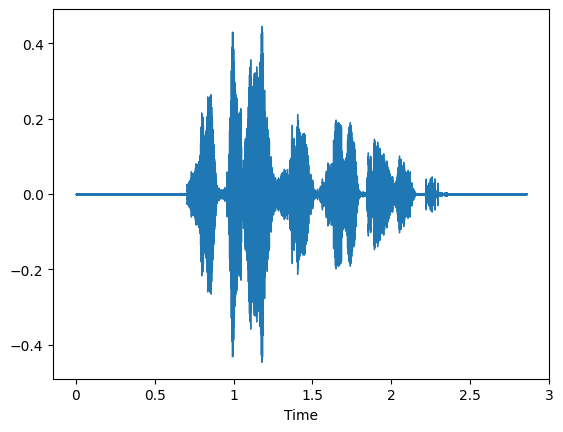

In [11]:
#example original audio
y,sr=librosa.load('EMOVO/EMOVO_dataset/f1/dis-f1-b1.wav')
librosa.display.waveshow(y=y, sr=sr)
Audio(y, rate=sr)

In [12]:
#add white noise to the original signal
def noise_addition(data,noise_percentage_factor=0.035):
    noise = np.random.normal(0, data.std(), data.size)
    augmented_data = data + noise * noise_percentage_factor
    return augmented_data

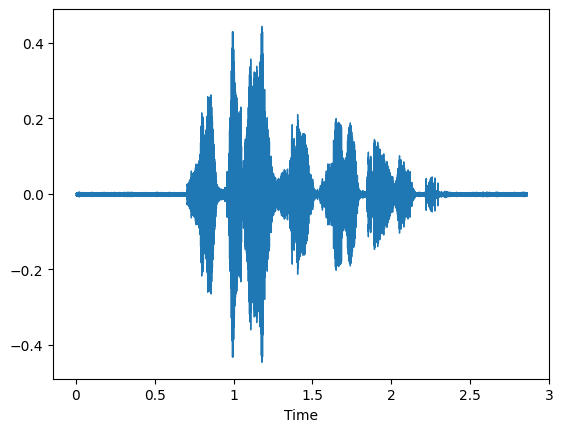

In [15]:
#example
y,sr=librosa.load('EMOVO/EMOVO_dataset/f1/dis-f1-b1.wav')
librosa.display.waveshow(y=noise_addition(y), sr=sr)
Audio(noise_addition(y), rate=sr)

In [21]:
#lower the pitch of the original signal
def pitch_scaling(data, sr, num_semitones=-2):
    return librosa.effects.pitch_shift(y = data,sr = sr,n_steps = num_semitones)

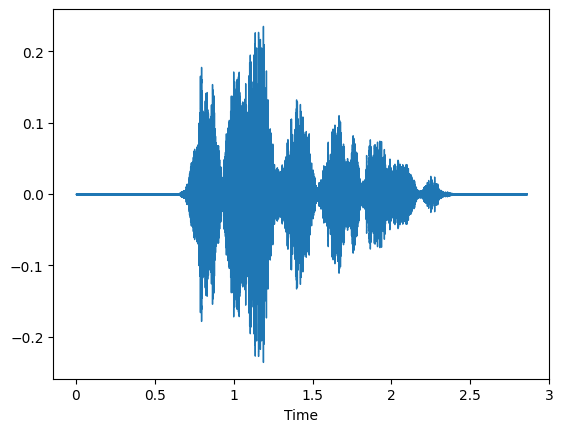

In [22]:
#example
y,sr=librosa.load('EMOVO/EMOVO_dataset/f1/dis-f1-b1.wav')
librosa.display.waveshow(y=pitch_scaling(y,sr=sr), sr=sr)
Audio(pitch_scaling(y,sr=sr), rate=sr)

In [23]:
#increase the pitch of the original signal
def pitch_scaling2(data, sr, num_semitones=2):
    return librosa.effects.pitch_shift(y = data,sr = sr,n_steps = num_semitones)
   

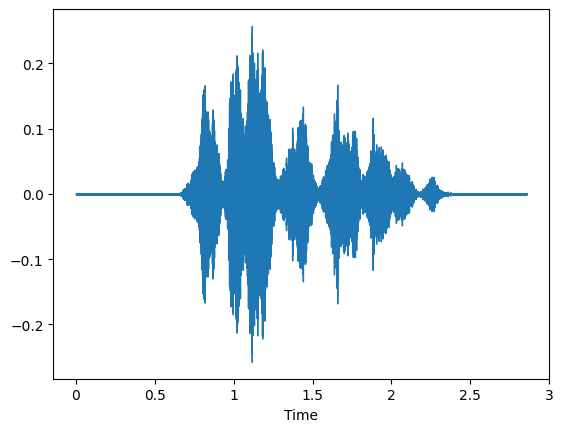

In [25]:
#example
y,sr=librosa.load('EMOVO/EMOVO_dataset/f1/dis-f1-b1.wav')
librosa.display.waveshow(y=pitch_scaling2(y,sr=sr), sr=sr)
Audio(pitch_scaling2(y,sr=sr), rate=sr)

#FEATURE EXTRACTION

In [27]:
#mfccs and deltas extraction
import math
def extract_mfccs_delta(path):
    y,sr=librosa.load(path)  
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
    else:
        y,sr=librosa.load(path)

    mfcc= librosa.feature.mfcc( y=y,  sr=sr, n_mfcc=13 )
    
    return mfcc

def extract_mfccs_delta_with_noise(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
        y=noise_addition(y)
    else:
        y,sr=librosa.load(path)
        y=noise_addition(y)
    mfcc= librosa.feature.mfcc( y=y,  sr=sr, n_mfcc=13 )
    
    return mfcc


def extract_mfccs_delta_with_pitch_scaling(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
        y=pitch_scaling(y,sr)
    else:
        y,sr=librosa.load(path)
        y=pitch_scaling(y,sr)
    mfcc= librosa.feature.mfcc( y=y,  sr=sr, n_mfcc=13 )
    
    return mfcc

def extract_mfccs_delta_with_pitch_scaling2(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
        y=pitch_scaling2(y,sr)
    else:
        y,sr=librosa.load(path)
        y=pitch_scaling2(y,sr)
    mfcc= librosa.feature.mfcc( y=y,  sr=sr, n_mfcc=13 )
    
    return mfcc

In [28]:
#log-mel spectrogram extraction
def extract_logmel(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
    else:
        y, sr = librosa.load(path)
    ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=60)
    ps_db= librosa.power_to_db(ps)
    return ps_db

def extract_logmel_with_noise(path):
  y, sr = librosa.load(path)
  duration=librosa.get_duration(y=y,sr=sr)
  #reduce the duration of files longer than 3 seconds
  if(duration > 3.0):
      y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
      y=noise_addition(y)
  else:
      y, sr = librosa.load(path)
      y=noise_addition(y)
  ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=60)
  ps_db= librosa.power_to_db(ps)
  return ps_db

def extract_logmel_with_pitch_scaling(path):
  y, sr = librosa.load(path)
  duration=librosa.get_duration(y=y,sr=sr)
  #reduce the duration of files longer than 3 seconds
  if(duration > 3.0):
      y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
      y=pitch_scaling(y,sr)
  else:
      y, sr = librosa.load(path)
      y=pitch_scaling(y,sr)
  ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=60)
  ps_db= librosa.power_to_db(ps)
  return ps_db
  

def extract_logmel_with_pitch_scaling2(path):
  y, sr = librosa.load(path)
  duration=librosa.get_duration(y=y,sr=sr)
  #reduce the duration of files longer than 3 seconds
  if(duration > 3.0):
      y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
      y=pitch_scaling2(y,sr)
  else:
      y, sr = librosa.load(path)
      y=pitch_scaling2(y,sr)
  ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=60)
  ps_db= librosa.power_to_db(ps)
  return ps_db

CREATION OF THE NOT AUGMENTED DATASET

In [34]:
not_aug_df = pd.read_csv("EMOVO/EMOVO_dataset/data.csv")

for i in range(0,13):
    not_aug_df["mfcc_"+str(i)]= None
    
for i in range(0,13):
    not_aug_df["delta_"+str(i)]= None
    
for i in range(0,60):
    not_aug_df["logmel_"+str(i)]= None

for  (index ,path) in tqdm(zip(not_aug_df.index,not_aug_df.file_name)):
        mfccs=extract_mfccs_delta('EMOVO/EMOVO_dataset/'+path)
        delta=librosa.feature.delta(mfccs)
        logmel=extract_logmel('EMOVO/EMOVO_dataset/'+path)
        #add zero padding
        if mfccs.shape[1]<130:
          mfccs=librosa.util.pad_center(mfccs, size=130, axis=1)
          delta=librosa.util.pad_center(delta, size=130, axis=1)
          logmel=librosa.util.pad_center(logmel, size=130, axis=1)
        for i in range(0,13):
            not_aug_df.at[index, "mfcc_"+str(i)] = mfccs[i]
        for j in range(0,13):
            not_aug_df.at[index, "delta_"+str(j)] = delta[j]
        for z in range(0,60):
            not_aug_df.at[index, "logmel_"+str(z)] = logmel[z]



0it [00:00, ?it/s]

588it [00:12, 45.39it/s]


CREATION OF THE DATASET AUGMENTED WITH PITCH SHIFTING




In [35]:
pitch_df = pd.read_csv("EMOVO/EMOVO_dataset/data.csv")
pitch_df= pd.concat([pitch_df]*2, ignore_index=True)   
for i in range(0,13):
    pitch_df["mfcc_"+str(i)]= None

for i in range(0,13):
    pitch_df["delta_"+str(i)]= None

for i in range(0,60):
    pitch_df["logmel_"+str(i)]= None

for  (index ,path) in zip(pitch_df[0:588].index,pitch_df[0:588].file_name):
        mfccs=extract_mfccs_delta_with_pitch_scaling('EMOVO/EMOVO_dataset/'+path)
        logmel=extract_logmel_with_pitch_scaling('EMOVO/EMOVO_dataset/'+path)
        delta=librosa.feature.delta(mfccs)
        #add zero padding
        if mfccs.shape[1]<130:
          mfccs=librosa.util.pad_center(mfccs, size=130, axis=1)
          delta=librosa.util.pad_center(delta, size=130, axis=1)
          logmel=librosa.util.pad_center(logmel, size=130, axis=1)
        for i in range(0,13):
            pitch_df.at[index, "mfcc_"+str(i)] = mfccs[i]
        for j in range(0,13):
            pitch_df.at[index, "delta_"+str(j)] = delta[j]
        for z in range(0,60):
            pitch_df.at[index, "logmel_"+str(z)] = logmel[z]
    
for  (index ,path) in zip(pitch_df[588:].index,pitch_df[588:].file_name):
        mfccs=extract_mfccs_delta_with_pitch_scaling2('EMOVO/EMOVO_dataset/'+path)
        logmel=extract_logmel_with_pitch_scaling2('EMOVO/EMOVO_dataset/'+path)
        delta=librosa.feature.delta(mfccs)
        #add zero padding
        if mfccs.shape[1]<130:
          mfccs=librosa.util.pad_center(mfccs, size=130, axis=1)
          delta=librosa.util.pad_center(delta, size=130, axis=1)
          logmel=librosa.util.pad_center(logmel, size=130, axis=1)
        for i in range(0,13):
            pitch_df.at[index, "mfcc_"+str(i)] = mfccs[i]
        for j in range(0,13):
            pitch_df.at[index, "delta_"+str(j)] = delta[j]
        for z in range(0,60):
            pitch_df.at[index, "logmel_"+str(z)] = logmel[z]


In [36]:
#join the two datasets
frames = [ not_aug_df, pitch_df]
semi_aug_df=pd.concat(frames ,ignore_index=True)

CREATION OF THE DATASET AUGMENTED WITH PITCH SHIFTING AND NOISE ADDITION

In [37]:
noise_df = pd.read_csv("EMOVO/EMOVO_dataset/data.csv")
for i in range(0,13):
    noise_df["mfcc_"+str(i)]= None
for i in range(0,13):
    noise_df["delta_"+str(i)]= None
for i in range(0,60):
    noise_df["logmel_"+str(i)]= None


for  (index ,path) in zip(noise_df.index,noise_df.file_name):
        mfccs=extract_mfccs_delta_with_noise('EMOVO/EMOVO_dataset/'+path)
        logmel=extract_logmel_with_noise('EMOVO/EMOVO_dataset/'+path)
        delta=librosa.feature.delta(mfccs)
        #add zero padding
        if mfccs.shape[1]<130:
          mfccs=librosa.util.pad_center(mfccs, size=130, axis=1)
          delta=librosa.util.pad_center(delta, size=130, axis=1)
          logmel=librosa.util.pad_center(logmel, size=130, axis=1)
        for i in range(0,13):
            noise_df.at[index, "mfcc_"+str(i)] = mfccs[i]
        for j in range(0,13):
            noise_df.at[index, "delta_"+str(j)] = delta[j]
        for z in range(0,60):
            noise_df.at[index, "logmel_"+str(z)] = logmel[z]



In [38]:
frames = [ semi_aug_df, noise_df]
aug_df=pd.concat(frames,ignore_index=True)

In [39]:
#encode the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(not_aug_df['label'])
not_aug_df['label_id']=le.transform(not_aug_df['label'])
semi_aug_df['label_id']=le.transform(semi_aug_df['label'])
aug_df['label_id']=le.transform(aug_df['label'])



In [40]:
#save the datasets in pickle files
not_aug_df.to_pickle('EMOVO/EMOVO_dataset/not_aug_df.pkl')
semi_aug_df.to_pickle('EMOVO/EMOVO_dataset/semi_aug_df.pkl')
aug_df.to_pickle('EMOVO/EMOVO_dataset/aug_df.pkl')


In [42]:
#read the pickle files
not_aug_df2=pd.read_pickle('EMOVO/EMOVO_dataset/not_aug_df.pkl')
semi_aug_df2=pd.read_pickle('EMOVO/EMOVO_dataset/semi_aug_df.pkl')
aug_df2=pd.read_pickle('EMOVO/EMOVO_dataset/aug_df.pkl')

In [46]:
#creation of the array containg the emotions ordered by their encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
sorted_labels=[]
label_encoder.fit(not_aug_df['label'])
name_mapping = dict(zip( label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
for i in range(7):
  sorted_labels.append(name_mapping[i])
sorted_labels

['anger', 'disgust', 'fear', 'joy', 'neutrality', 'sadness', 'surprise']

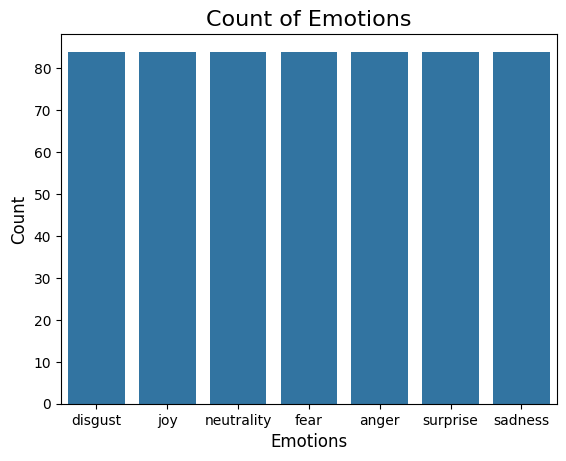

In [47]:
#ahow class balance
plt.title('Count of Emotions', size=16)
sns.countplot(x= not_aug_df['label'])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

# K-MEANS

In [48]:
scaler = StandardScaler()
          

In [49]:
#extraction of the mfccs from the datasets - not aug
X_mfccs_k = np.array(not_aug_df.iloc[:, 3:29])
X_mfccs_k=np.array(X_mfccs_k.tolist())
X_mfccs_k=scaler.fit_transform(X_mfccs_k.reshape(-1, X_mfccs_k.shape[-1])).reshape(X_mfccs_k.shape)
Y_mfccs_k=not_aug_df['label']

In [50]:
#extraction of the log mel specrogram from the datasets - not aug
X_logmel_k = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel_k=np.array(X_logmel_k.tolist())
X_logmel_k=scaler.fit_transform(X_logmel_k.reshape(-1, X_logmel_k.shape[-1])).reshape(X_logmel_k.shape)
Y_logmel_k=not_aug_df['label']

In [51]:
len(X_mfccs_k)

588

In [52]:
#reshape the data from 3D to 2D - not aug
X_mfccs_k=X_mfccs_k.reshape(X_mfccs_k.shape[0],X_mfccs_k.shape[1]*X_mfccs_k.shape[2])
X_logmel_k=X_logmel_k.reshape(X_logmel_k.shape[0],X_logmel_k.shape[1]*X_logmel_k.shape[2])


In [53]:
X_logmel_k.shape

(588, 7800)

**PCA**

In [54]:
#perform PCA to have two features
pca = PCA(n_components=2)
principalComponents_mfccs = pca.fit_transform(X_mfccs_k)
principalComponents_logmel = pca.fit_transform(X_logmel_k)

In [55]:
reduced_df_mfccs = pd.DataFrame(data = principalComponents_mfccs
             , columns = ['principal component 1', 'principal component 2'])
reduced_df_logmel = pd.DataFrame(data = principalComponents_logmel
             , columns = ['principal component 1', 'principal component 2'])

**K-MEANS WITH 7 CLUSTERS (NUMBER OF EMOTIONS)**

In [56]:
#perform k-means
kmeans_mfccs = KMeans(n_clusters=7, random_state=None).fit(reduced_df_mfccs)
kmeans_logmel = KMeans(n_clusters=7, random_state=None).fit(reduced_df_logmel)

In [57]:
#creation of the classes obtained through k-means
labels_mfccs=kmeans_mfccs.predict(reduced_df_mfccs)
labels_logmel=kmeans_logmel.predict(reduced_df_logmel)

Text(0.5, 1.0, 'log-mel spectrogram')

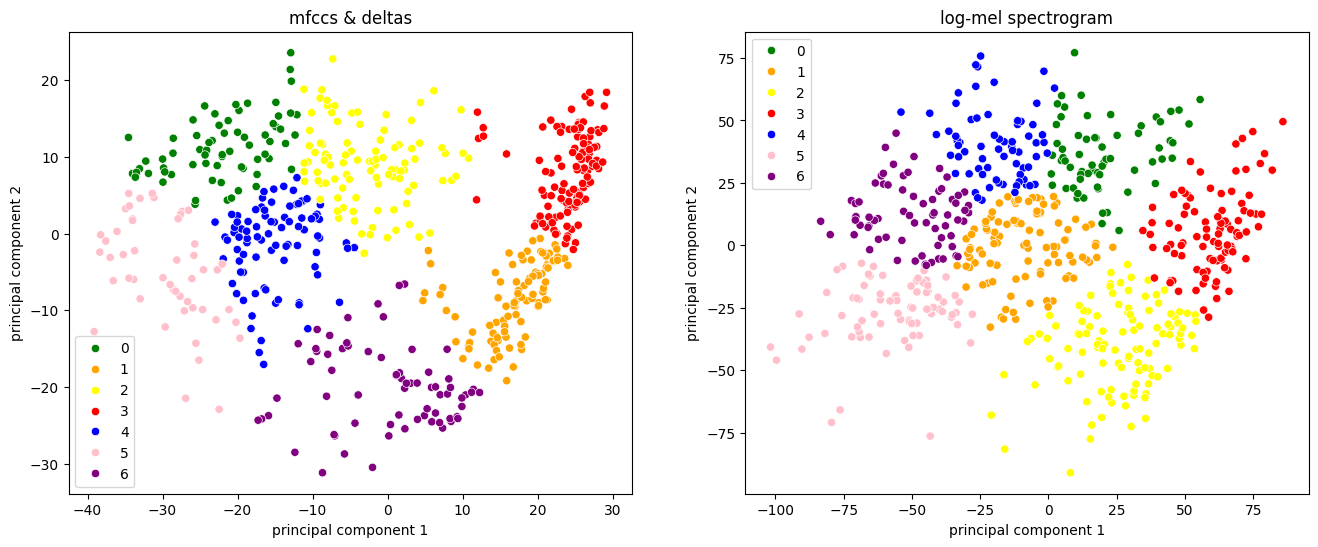

In [59]:
#plot the clusters
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=reduced_df_mfccs, x='principal component 1', y='principal component 2',hue=labels_mfccs, palette=['green','orange','yellow','red','blue','pink','purple'])  
sns.scatterplot(ax=axes[1],data=reduced_df_logmel, x='principal component 1', y='principal component 2', hue=labels_logmel,palette=['green','orange','yellow','red','blue','pink','purple']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")





**FIND THE OPTIMAL NUMBER OF CLUSTERS THROUGH SILHOUETTE SCORE**

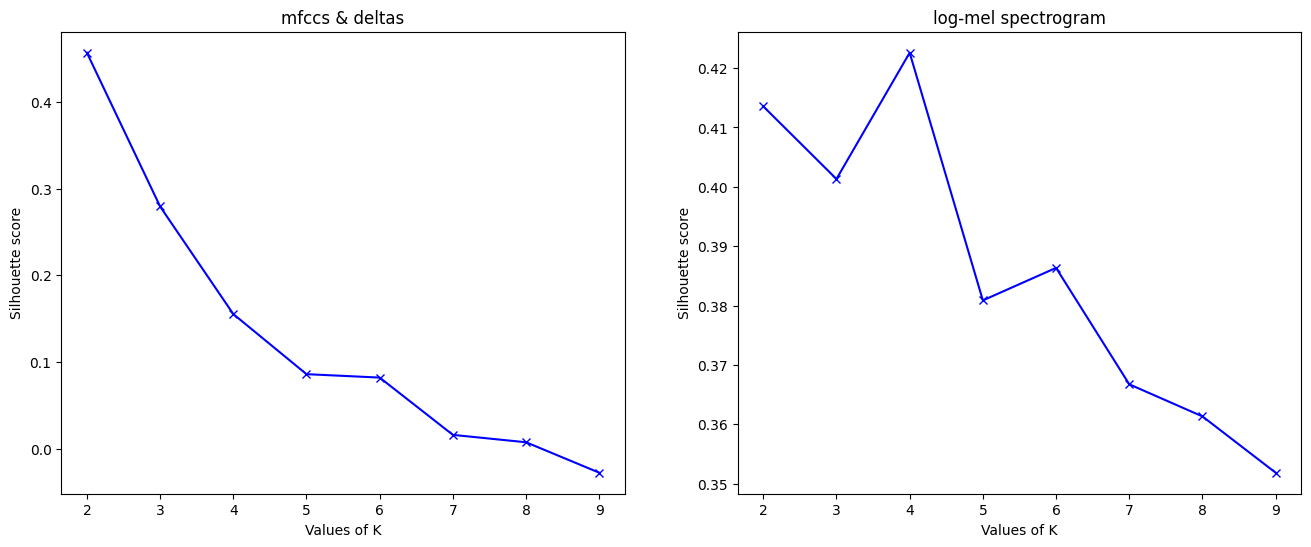

In [60]:
silhouette_avg_mfccs=[]
silhouette_avg_logmel = []
for i in range(2,10):
 
 # initialise kmeans
 kmeans_mfccs = KMeans(n_clusters=i)
 kmeans_logmel = KMeans(n_clusters=i)
 kmeans_mfccs.fit(reduced_df_mfccs)
 kmeans_logmel.fit(reduced_df_logmel)
 cluster_labels_mfccs = kmeans_mfccs.predict(reduced_df_logmel)
 cluster_labels_logmel=kmeans_logmel.predict(reduced_df_logmel)
 # silhouette score
 silhouette_avg_mfccs.append(silhouette_score(reduced_df_mfccs, cluster_labels_mfccs))
 silhouette_avg_logmel.append(silhouette_score(reduced_df_logmel, cluster_labels_logmel))
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
axes[0].plot(range(2,10),silhouette_avg_mfccs,"-bx")

axes[1].plot(range(2,10),silhouette_avg_logmel,"-bx")
plt.title("Silhouette analysis For Optimal k")
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
for ax in axes.flat:
    ax.set(xlabel="Values of K", ylabel='Silhouette score')
plt.show()

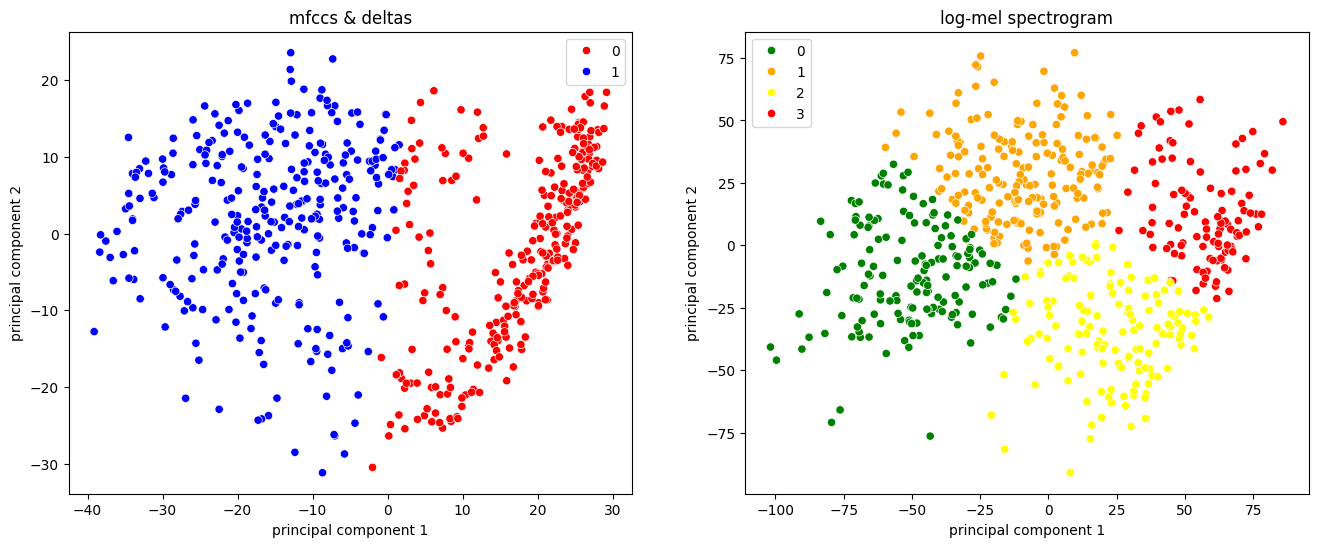

In [62]:
#perform k-means
kmeans_mfccs = KMeans(n_clusters=2, random_state=None).fit(reduced_df_mfccs)
kmeans_logmel = KMeans(n_clusters=4, random_state=None).fit(reduced_df_logmel)
#creation of the classes obtained through k-means
labels_mfccs=kmeans_mfccs.predict(reduced_df_mfccs)
labels_logmel=kmeans_logmel.predict(reduced_df_logmel)
#plot the clusters
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=reduced_df_mfccs, x='principal component 1', y='principal component 2',hue=labels_mfccs, palette=['red','blue'])  
sns.scatterplot(ax=axes[1],data=reduced_df_logmel, x='principal component 1', y='principal component 2', hue=labels_logmel,palette=['green','orange','yellow','red']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
plt.show()

# FEATURE SPACE WITH TRUE DISTRIBUTION

TRUE DISTRIBUTION - NOT AUGMENTED

In [63]:
#extraction of the mfccs from the datasets - not aug
X_mfccs_k_not = np.array(not_aug_df.iloc[:, 3:29])
X_mfccs_k_not=np.array(X_mfccs_k_not.tolist())
X_mfccs_k_not=scaler.fit_transform(X_mfccs_k_not.reshape(-1, X_mfccs_k_not.shape[-1])).reshape(X_mfccs_k_not.shape)
Y_mfccs_k_not=not_aug_df['label']
#extraction of the log mel specrogram from the datasets - not aug
X_logmel_k_not = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel_k_not=np.array(X_logmel_k_not.tolist())
X_logmel_k_not=scaler.fit_transform(X_logmel_k_not.reshape(-1, X_logmel_k_not.shape[-1])).reshape(X_logmel_k_not.shape)
Y_logmel_k_not=not_aug_df['label']
#reshape the data from 3D to 2D - not aug
X_mfccs_k_not=X_mfccs_k_not.reshape(X_mfccs_k_not.shape[0],X_mfccs_k_not.shape[1]*X_mfccs_k_not.shape[2])
X_logmel_k_not=X_logmel_k_not.reshape(X_logmel_k_not.shape[0],X_logmel_k_not.shape[1]*X_logmel_k_not.shape[2])

In [64]:
#perform PCA to have two features
pca = PCA(n_components=2)
principalComponents_mfccs = pca.fit_transform(X_mfccs_k_not)
principalComponents_logmel = pca.fit_transform(X_logmel_k_not)

In [65]:
reduced_df_mfccs = pd.DataFrame(data = principalComponents_mfccs
             , columns = ['principal component 1', 'principal component 2'])
reduced_df_logmel = pd.DataFrame(data = principalComponents_logmel
             , columns = ['principal component 1', 'principal component 2'])

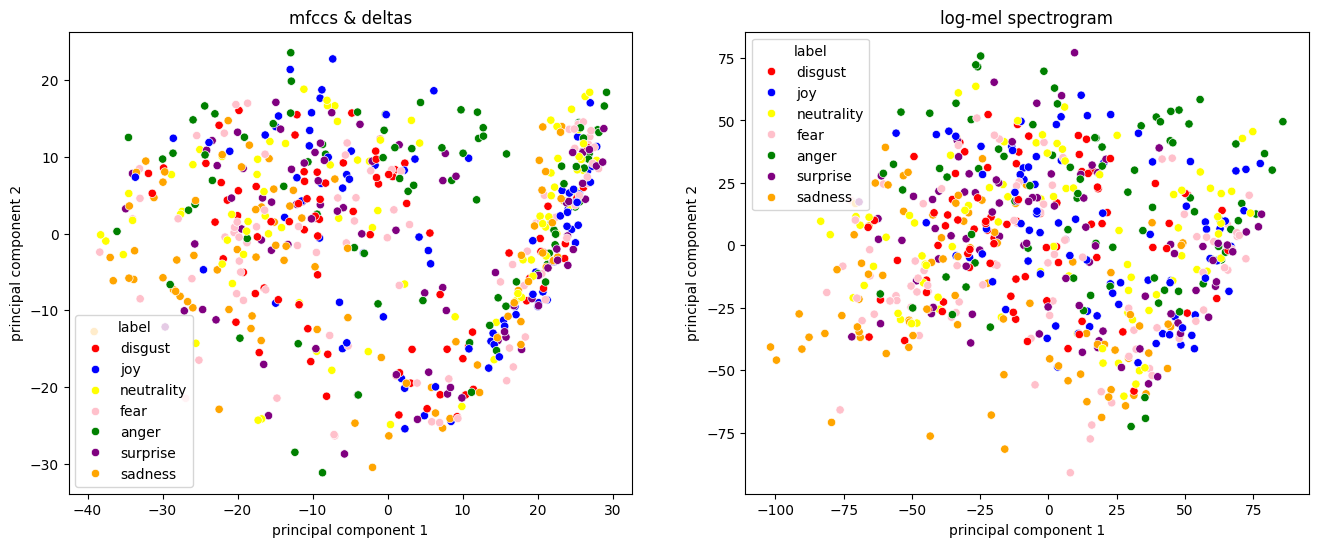

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=reduced_df_mfccs, x='principal component 1', y='principal component 2',hue=Y_mfccs_k_not, palette=['red','blue','yellow','pink','green','purple','orange'])  
sns.scatterplot(ax=axes[1],data=reduced_df_logmel, x='principal component 1', y='principal component 2', hue=Y_logmel_k_not,palette=['red','blue','yellow','pink','green','purple','orange']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
plt.show()

In [68]:
#perform TSNE
tsne = TSNE(2, perplexity=30)
tsne_result_mfccs = tsne.fit_transform(X_mfccs_k_not)
tsne_result_logmel = tsne.fit_transform(X_logmel_k_not)
tsne_df_mfccs = pd.DataFrame(data=tsne_result_mfccs, columns=['tsne_1','tsne_2'])
tsne_df_logmel = pd.DataFrame(data=tsne_result_logmel , columns=['tsne_1','tsne_2'])
print(tsne_result_logmel.shape)

(588, 2)


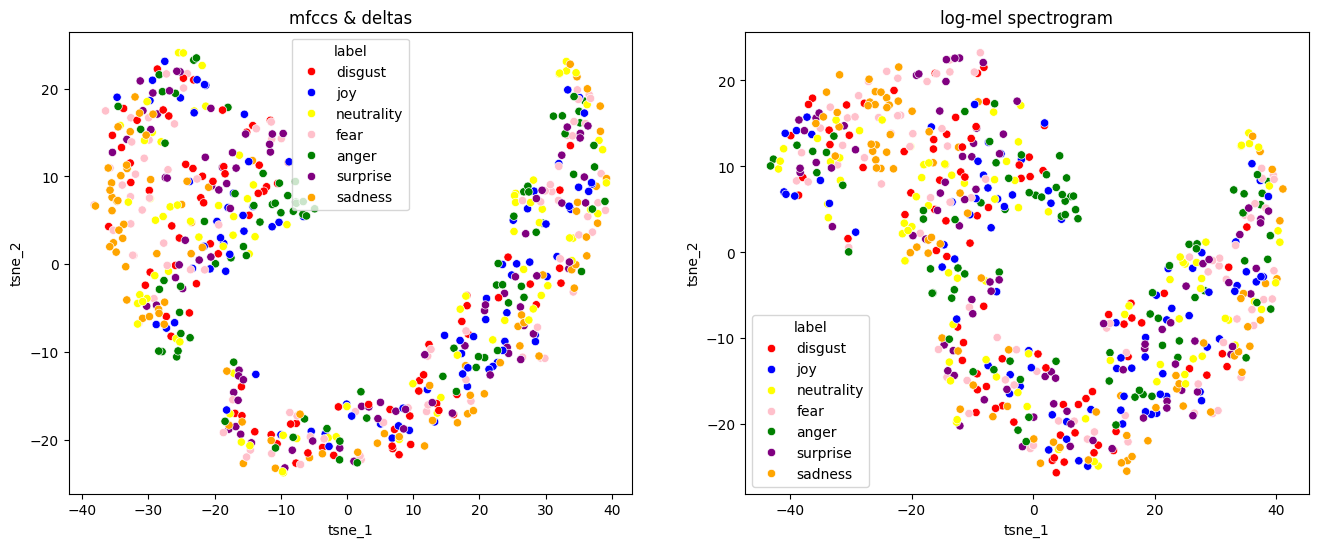

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=tsne_df_mfccs, x='tsne_1', y='tsne_2',hue=Y_mfccs_k_not, palette=['red','blue','yellow','pink','green','purple','orange'])  
sns.scatterplot(ax=axes[1],data=tsne_df_logmel, x='tsne_1', y='tsne_2', hue=Y_logmel_k_not,palette=['red','blue','yellow','pink','green','purple','orange']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
plt.show()

TRUE DISTRIBUTION -  AUGMENTED DATA WITH PITCH SCALING

In [70]:
#extraction of the mfccs from the datasets
X_mfccs_k_semi = np.array(semi_aug_df.iloc[:, 3:29])
X_mfccs_k_semi=np.array(X_mfccs_k_semi.tolist())
X_mfccs_k_semi=scaler.fit_transform(X_mfccs_k_semi.reshape(-1, X_mfccs_k_semi.shape[-1])).reshape(X_mfccs_k_semi.shape)
Y_mfccs_k_semi=semi_aug_df['label']
#extraction of the log mel specrogram from the datasets
X_logmel_k_semi = np.array(semi_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel_k_semi=np.array(X_logmel_k_semi.tolist())
X_logmel_k_semi=scaler.fit_transform(X_logmel_k_semi.reshape(-1, X_logmel_k_semi.shape[-1])).reshape(X_logmel_k_semi.shape)
Y_logmel_k_semi=semi_aug_df['label']
#reshape the data from 3D to 2D
X_mfccs_k_semi=X_mfccs_k_semi.reshape(X_mfccs_k_semi.shape[0],X_mfccs_k_semi.shape[1]*X_mfccs_k_semi.shape[2])
X_logmel_k_semi=X_logmel_k_semi.reshape(X_logmel_k_semi.shape[0],X_logmel_k_semi.shape[1]*X_logmel_k_semi.shape[2])


In [71]:
#perform PCA to have two features
pca = PCA(n_components=2)
principalComponents_mfccs = pca.fit_transform(X_mfccs_k_semi)
principalComponents_logmel = pca.fit_transform(X_logmel_k_semi)
reduced_df_mfccs = pd.DataFrame(data = principalComponents_mfccs
             , columns = ['principal component 1', 'principal component 2'])
reduced_df_logmel = pd.DataFrame(data = principalComponents_logmel
             , columns = ['principal component 1', 'principal component 2'])

C:\Users\anton\AppData\Local\Temp\ipykernel_39252\1474056483.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


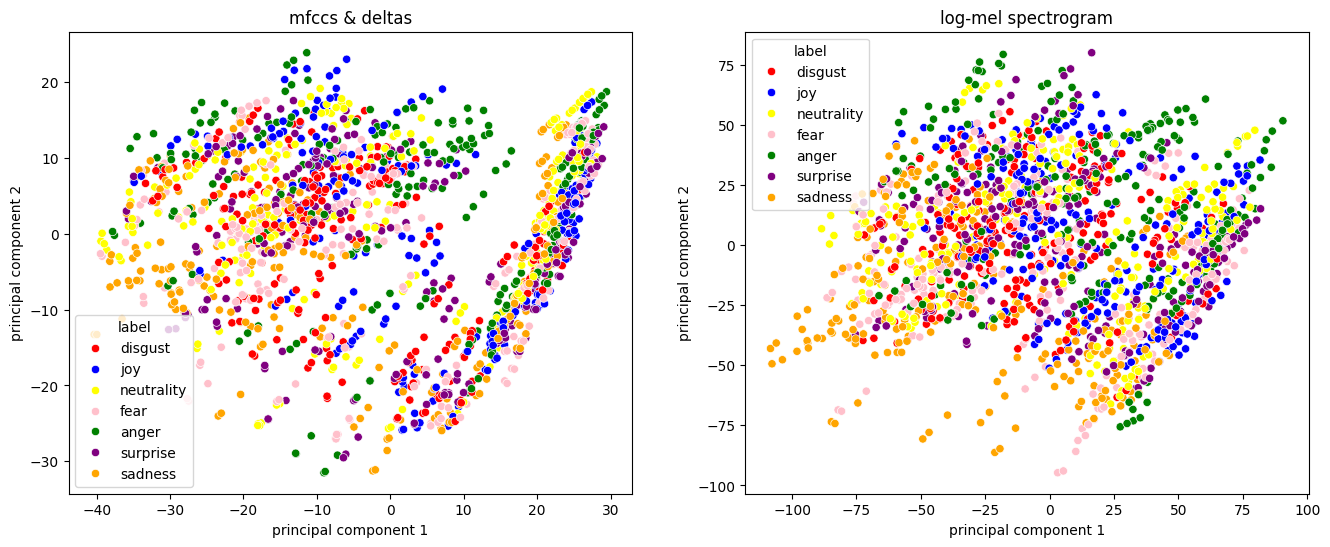

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=reduced_df_mfccs, x='principal component 1', y='principal component 2',hue=Y_mfccs_k_semi, palette=['red','blue','yellow','pink','green','purple','orange'])  
sns.scatterplot(ax=axes[1],data=reduced_df_logmel, x='principal component 1', y='principal component 2', hue=Y_logmel_k_semi,palette=['red','blue','yellow','pink','green','purple','orange']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
fig.show()

In [73]:
#perform TSNE
tsne = TSNE(2,perplexity=30)
tsne_result_mfccs = tsne.fit_transform(X_mfccs_k_semi)
tsne_result_logmel = tsne.fit_transform(X_logmel_k_semi)
tsne_df_mfccs = pd.DataFrame(data=tsne_result_mfccs, columns =['tsne_1','tsne_2'])
tsne_df_logmel = pd.DataFrame(data=tsne_result_logmel , columns =['tsne_1','tsne_2'])
print(tsne_result_logmel.shape)

(1764, 2)


C:\Users\anton\AppData\Local\Temp\ipykernel_39252\2317842659.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


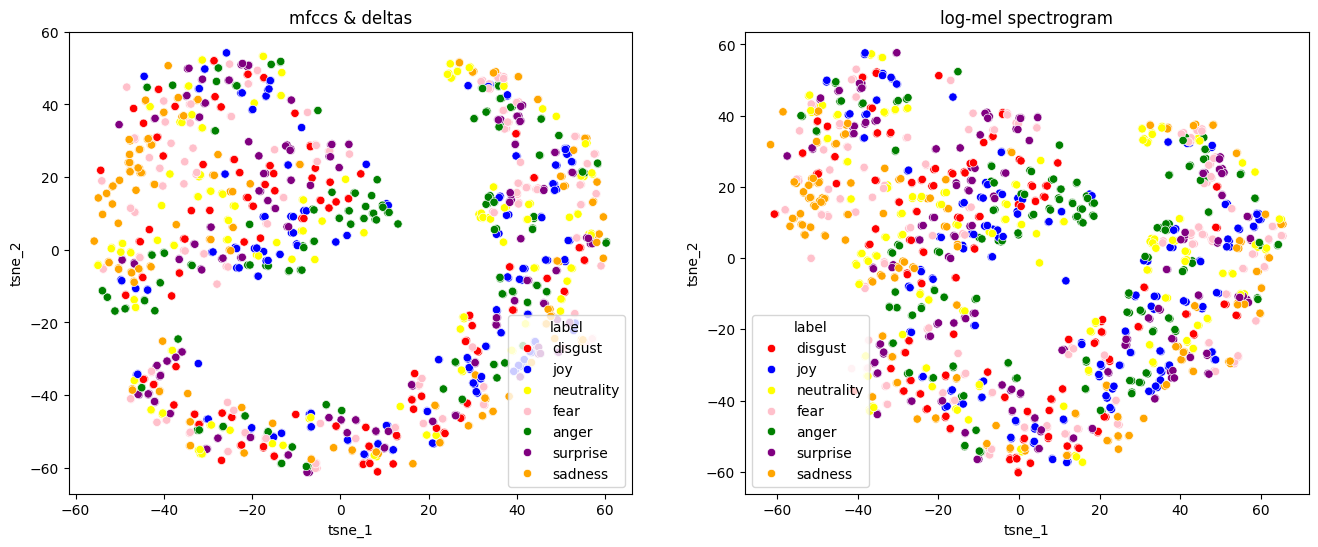

In [74]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=tsne_df_mfccs, x='tsne_1', y='tsne_2',hue=Y_mfccs_k_semi, palette=['red','blue','yellow','pink','green','purple','orange'])  
sns.scatterplot(ax=axes[1],data=tsne_df_logmel, x='tsne_1', y='tsne_2', hue=Y_logmel_k_semi,palette=['red','blue','yellow','pink','green','purple','orange']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
fig.show()

TRUE DISTRIBUTION - AUGMENTED DATA WITH PITCH SHIFTING AND NOISE ADDITION

In [75]:
#extraction of the mfccs from the datasets
X_mfccs_k_aug = np.array(aug_df.iloc[:, 3:29])
X_mfccs_k_aug=np.array(X_mfccs_k_aug.tolist())
X_mfccs_k_aug=scaler.fit_transform(X_mfccs_k_aug.reshape(-1, X_mfccs_k_aug.shape[-1])).reshape(X_mfccs_k_aug.shape)
Y_mfccs_k_aug=aug_df['label']
#extraction of the log mel specrogram from the datasets
X_logmel_k_aug = np.array(aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel_k_aug=np.array(X_logmel_k_aug.tolist())
X_logmel_k_aug=scaler.fit_transform(X_logmel_k_aug.reshape(-1, X_logmel_k_aug.shape[-1])).reshape(X_logmel_k_aug.shape)
Y_logmel_k_aug=aug_df['label']
#reshape the data from 3D to 2D
X_mfccs_k_aug=X_mfccs_k_aug.reshape(X_mfccs_k_aug.shape[0],X_mfccs_k_aug.shape[1]*X_mfccs_k_aug.shape[2])
X_logmel_k_aug=X_logmel_k_aug.reshape(X_logmel_k_aug.shape[0],X_logmel_k_aug.shape[1]*X_logmel_k_aug.shape[2])

In [76]:
#perform PCA to have two features
pca = PCA(n_components=2)
principalComponents_mfccs = pca.fit_transform(X_mfccs_k_aug)
principalComponents_logmel = pca.fit_transform(X_logmel_k_aug)
reduced_df_mfccs = pd.DataFrame(data = principalComponents_mfccs
             , columns = ['principal component 1', 'principal component 2'])
reduced_df_logmel = pd.DataFrame(data = principalComponents_logmel
             , columns = ['principal component 1', 'principal component 2'])

C:\Users\anton\AppData\Local\Temp\ipykernel_39252\4184899650.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


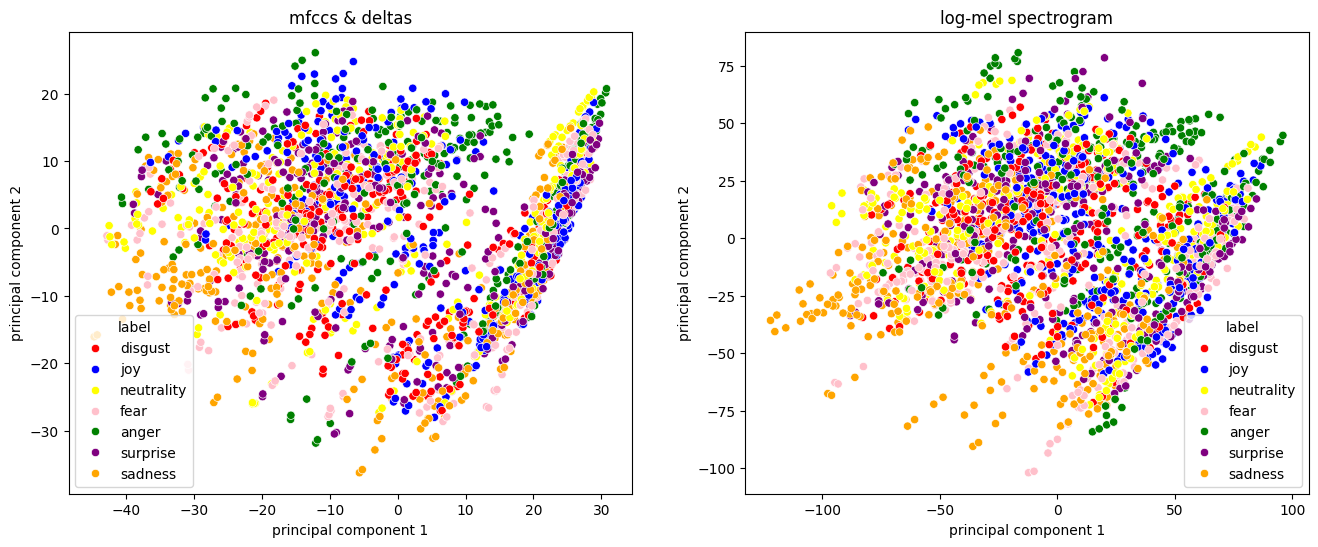

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=reduced_df_mfccs, x='principal component 1', y='principal component 2',hue=Y_mfccs_k_aug, palette=['red','blue','yellow','pink','green','purple','orange'])  
sns.scatterplot(ax=axes[1],data=reduced_df_logmel, x='principal component 1', y='principal component 2', hue=Y_logmel_k_aug,palette=['red','blue','yellow','pink','green','purple','orange']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
fig.show()

In [78]:
#perform TSNE
tsne = TSNE(2,perplexity=30)
tsne_result_mfccs_aug = tsne.fit_transform(X_mfccs_k_aug)
tsne_result_logmel_aug = tsne.fit_transform(X_logmel_k_aug)
tsne_df_mfccs_aug = pd.DataFrame(data=tsne_result_mfccs_aug, columns= ['tsne_1','tsne_2'])
tsne_df_logmel_aug = pd.DataFrame(data=tsne_result_logmel_aug , columns= ['tsne_1','tsne_2'])

C:\Users\anton\AppData\Local\Temp\ipykernel_39252\1007180041.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


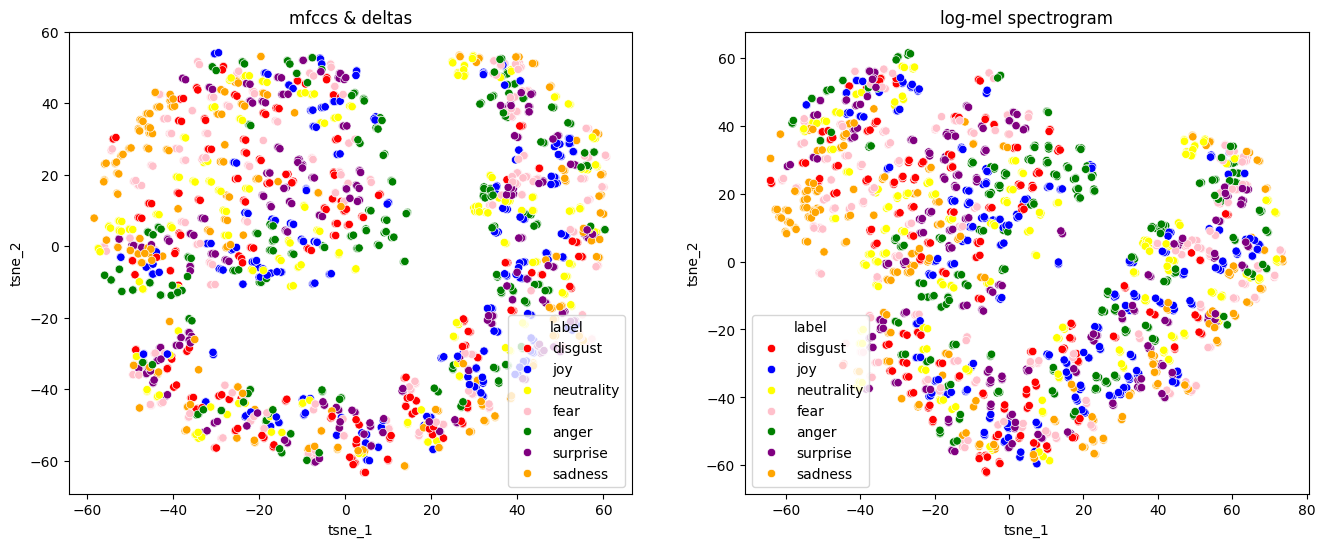

In [79]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.scatterplot(ax=axes[0],data=tsne_df_mfccs_aug, x='tsne_1', y='tsne_2',hue=Y_mfccs_k_aug, palette=['red','blue','yellow','pink','green','purple','orange'])  
sns.scatterplot(ax=axes[1],data=tsne_df_logmel_aug, x='tsne_1', y='tsne_2', hue=Y_logmel_k_aug,palette=['red','blue','yellow','pink','green','purple','orange']) 
axes[0].set_title("mfccs & deltas" )
axes[1].set_title("log-mel spectrogram")
fig.show()

#MODELING

CREATION OF MODELS INPUTS

In [80]:
#extraction of labels_id from datasets
Y_not_aug=not_aug_df['label_id']
Y_semi_aug=semi_aug_df['label_id']
Y_aug=aug_df['label_id']


In [81]:
#take the log mel spectrogram from the datasets
X_logmel = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel=np.array(X_logmel.tolist())
X_logmel_semi_aug = np.array(semi_aug_df.loc[:, ['logmel' in i for i in semi_aug_df.columns]])
X_logmel_semi_aug=np.array(X_logmel_semi_aug.tolist())
X_logmel_aug = np.array(aug_df.loc[:, ['logmel' in i for i in aug_df.columns]])
X_logmel_aug=np.array(X_logmel_aug.tolist())

In [82]:
#take the mfccs & deltas from the datasets
X_mfccs = np.array(not_aug_df.iloc[:, 3:29]) 
X_mfccs=np.array(X_mfccs.tolist())
X_mfccs_semi_aug = np.array(semi_aug_df.iloc[:, 3:29])
X_mfccs_semi_aug=np.array(X_mfccs_semi_aug.tolist())
X_mfccs_aug = np.array(aug_df.iloc[:, 3:29])
X_mfccs_aug=np.array(X_mfccs_aug.tolist())

In [83]:
print(X_mfccs_semi_aug.shape)
print(X_logmel_semi_aug.shape)

(1764, 26, 130)
(1764, 60, 130)


STRATIFIED K-FOLD CROSS VALIDATION

In [84]:
#create the  stratified k-fold generator of test and training data
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
generator = StratifiedShuffleSplit(n_splits=10)

In [85]:
#function for the creation of the confusion matrix
def create_confusion_matrix(confusion_matrix):
    labels=sorted_labels
    column= [f'predicted {label}'for label in labels]
    indeces=  [f'true {label}'
               for label in labels]
    matrix= pd.DataFrame(data=confusion_matrix,columns=column, index=indeces )
    return sns.heatmap(matrix, annot=True, fmt='d', cmap="YlGnBu")

In [86]:
#function used to create the ROC curve
def create_general_roc_curve(fpr, tpr):
  colors = cycle(["aqua", "red", "blue","green","yellow","orange","purple"])
  for i, color,label in zip(range(7), colors, sorted_labels):
    plt.plot( 
        [0,fpr[i],1],
        [0,tpr[i],1],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(label,auc([0,fpr[i],1],[0, tpr[i],1]) ),
    )

  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

In [87]:
def calculate_scores(conf_mat):
  precisions=dict.fromkeys([0,1,2,3,4,5,6])
  recalls=dict.fromkeys([0,1,2,3,4,5,6])
  f1s=dict.fromkeys([0,1,2,3,4,5,6])
  fpr=dict.fromkeys([0,1,2,3,4,5,6])
  for i in range(7):
    tp=conf_mat[i][i]
    sum_fp=0
    for z in [x for x in range(7) if x != i]:
      sum_fp+= conf_mat[z][i]
    fp=sum_fp
    precision=tp/(tp+fp)
    precisions[i]=precision
    sum_fn=0
    for z in [x for x in range(7) if x != i]:
      sum_fn+=conf_mat[i][z]
    fn=sum_fn
    recall=tp/(tp+fn)
    recalls[i]=recall
    f1=2*(precision*recall)/(precision+recall)
    f1s[i]=f1
    sum_tn=0
    for z in [x for x in range(7) if x != i]:
      sum_tn+=conf_mat[z][z]
    fpr[i]=fp/(fp+sum_tn)
  return precisions,recalls,f1s,fpr

**CNN**

In [88]:
#add one dimension to data to make them suitable foR CNN
X_logmel = np.reshape(X_logmel, (X_logmel.shape[0],X_logmel.shape[1],X_logmel.shape[2],1))
X_logmel_semi_aug= np.reshape(X_logmel_semi_aug, (X_logmel_semi_aug.shape[0],X_logmel_semi_aug.shape[1],X_logmel_semi_aug.shape[2],1))
X_logmel_aug= np.reshape(X_logmel_aug, (X_logmel_aug.shape[0],X_logmel_aug.shape[1],X_logmel_aug.shape[2],1))

In [89]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()


  modelcnn.add(keras.layers.Conv2D(32, (2, 6), activation='relu', input_shape=input_data,kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7), strides=(2,2),padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))
  
  modelcnn.add(keras.layers.Conv2D(64, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2,7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(128, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(256, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))
  modelcnn.add(keras.layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

PERFORMANCE EVALUATION OF CNN - NOT AUGMENTED DATA


In [90]:
input_data=(X_logmel.shape[1:])
histories_cnn = []
confusion_matrices_cnn=[]
results_cnn=[]
actual_labels_cnn=np.array([])
predicted_labels_cnn=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_logmel, Y_not_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
            # get the training and test data
            train_X, test_X = X_logmel[train_indices], X_logmel[test_indices]
            train_y, test_y = Y_not_aug[train_indices], Y_not_aug[test_indices]
            actual_labels_cnn=np.append(actual_labels_cnn,test_y)
            #normalize the data
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
            test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
            print(train_X.shape)
            modelcnn=create_cnn(input_data)
            modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=256,epochs=1000,callbacks=[EarlyStopping(patience=10,monitor="loss")])
            histories_cnn.append(history)
            pred=modelcnn.predict(test_X)
            pred=pred.argmax(axis=1)
            predicted_labels_cnn=np.append(predicted_labels_cnn,pred)
            conf_matr=confusion_matrix(test_y,pred)
            confusion_matrices_cnn.append(conf_matr)
            results = modelcnn.evaluate(test_X, test_y, batch_size=128)
            results_cnn.append(results)
            
            

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(529, 60, 130, 1)
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.1341 - loss: 2.6572 - val_accuracy: 0.1356 - val_loss: 2.5700
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1383 - loss: 2.5771 - val_accuracy: 0.2034 - val_loss: 2.5487
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.1751 - loss: 2.5386 - val_accuracy: 0.2203 - val_loss: 2.5238
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.1787 - loss: 2.5078 - val_accuracy: 0.2373 - val_loss: 2.4941
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.1983 - loss: 2.4716 - val_accuracy: 0.2542 - val_loss: 2.4566
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.2314 - loss: 2.4313 - val_accuracy: 0.3051 - val_loss: 2.4351
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.1951 - loss: 2.4346 - val_accuracy: 0.2373 - val_loss: 2.4146
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.2214 - loss: 2.3818 

Computing k-fold:  10%|█         | 1/10 [02:10<19:30, 130.06s/it]

(529, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.1263 - loss: 2.6782 - val_accuracy: 0.1864 - val_loss: 2.5713
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.1566 - loss: 2.5923 - val_accuracy: 0.1525 - val_loss: 2.5559
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.1393 - loss: 2.5612 - val_accuracy: 0.1525 - val_loss: 2.5387
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.1581 - loss: 2.5339 - val_accuracy: 0.1525 - val_loss: 2.5211
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.1422 - loss: 2.5177 - val_accuracy: 0.1525 - val_loss: 2.5032
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.1436 - loss: 2.5001 - val_accuracy: 0.1525 - val_loss: 2.4854
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.1374 - loss: 2.4834 - val_accuracy: 0.1864 - val_loss: 2.4677
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.1570 - loss: 2.4632 - val_accuracy: 0.1525 - val_lo

Computing k-fold:  20%|██        | 2/10 [04:43<19:11, 143.98s/it]

(529, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.1321 - loss: 2.6706 - val_accuracy: 0.1695 - val_loss: 2.5721
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.1414 - loss: 2.5826 - val_accuracy: 0.1695 - val_loss: 2.5549
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.1749 - loss: 2.5442 - val_accuracy: 0.1864 - val_loss: 2.5381
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.1507 - loss: 2.5229 - val_accuracy: 0.1695 - val_loss: 2.5178
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.1806 - loss: 2.4934 - val_accuracy: 0.2034 - val_loss: 2.4929
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.1787 - loss: 2.4644 - val_accuracy: 0.1864 - val_loss: 2.4571
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.2273 - loss: 2.4195 - val_accuracy: 0.1864 - val_loss: 2.4117
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.2381 - loss: 2.4183 - val_accuracy: 0.2542 - val_lo

Computing k-fold:  30%|███       | 3/10 [07:28<17:53, 153.38s/it]

(529, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.1566 - loss: 2.6526 - val_accuracy: 0.1356 - val_loss: 2.5697
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.1608 - loss: 2.5870 - val_accuracy: 0.2203 - val_loss: 2.5513
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.1571 - loss: 2.5632 - val_accuracy: 0.2542 - val_loss: 2.5325
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.1858 - loss: 2.5423 - val_accuracy: 0.2373 - val_loss: 2.5126
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.1897 - loss: 2.5071 - val_accuracy: 0.2542 - val_loss: 2.4874
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.2186 - loss: 2.4706 - val_accuracy: 0.2542 - val_loss: 2.4576
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.2042 - loss: 2.4408 - val_accuracy: 0.2542 - val_loss: 2.4270
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.2264 - loss: 2.4005 - val_accuracy: 0.2373 - val_lo

Computing k-fold:  40%|████      | 4/10 [09:34<14:16, 142.81s/it]c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(529, 60, 130, 1)
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.1166 - loss: 2.6570 - val_accuracy: 0.2034 - val_loss: 2.5688
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - accuracy: 0.1441 - loss: 2.5902 - val_accuracy: 0.1525 - val_loss: 2.5534
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.1341 - loss: 2.5558 - val_accuracy: 0.1695 - val_loss: 2.5341
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - accuracy: 0.1551 - loss: 2.5271 - val_accuracy: 0.1356 - val_loss: 2.5091
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.1643 - loss: 2.5008 - val_accuracy: 0.2373 - val_loss: 2.4805
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.2143 - loss: 2.4682 - val_accuracy: 0.1864 - val_loss: 2.4467
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.2056 - loss: 2.4523 - val_accuracy: 0.2881 - val_loss: 2.4121
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.2007 - loss: 2.4141 

Computing k-fold:  50%|█████     | 5/10 [11:42<11:27, 137.41s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step - accuracy: 0.1532 - loss: 2.6465 - val_accuracy: 0.2034 - val_loss: 2.5687
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step - accuracy: 0.1671 - loss: 2.5730 - val_accuracy: 0.1356 - val_loss: 2.5494
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 0.1724 - loss: 2.5485 - val_accuracy: 0.1525 - val_loss: 2.5288
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.1658 - loss: 2.5284 - val_accuracy: 0.1186 - val_loss: 2.5080
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.1738 - loss: 2.4959 - val_accuracy: 0.1356 - val_loss: 2.4803
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step - accuracy: 0.1883 - loss: 2.4645 - val_accuracy: 0.2203 - val_loss: 2.4404
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.2334 - loss: 2.4163 - val_accuracy: 0.2373 - val_loss: 2.4009
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 0.2045 - loss: 2.3894 - val_accuracy: 0.

Computing k-fold:  60%|██████    | 6/10 [14:50<10:17, 154.44s/it]

(529, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.1349 - loss: 2.6476 - val_accuracy: 0.1356 - val_loss: 2.5663
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.1475 - loss: 2.5836 - val_accuracy: 0.3390 - val_loss: 2.5463
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - accuracy: 0.1783 - loss: 2.5479 - val_accuracy: 0.3051 - val_loss: 2.5243
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.1964 - loss: 2.5018 - val_accuracy: 0.2034 - val_loss: 2.4948
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.2018 - loss: 2.4689 - val_accuracy: 0.2542 - val_loss: 2.4566
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.2354 - loss: 2.4350 - val_accuracy: 0.2203 - val_loss: 2.4198
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.2234 - loss: 2.3965 - val_accuracy: 0.2203 - val_loss: 2.3944
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.2382 - loss: 2.3748 - val_accuracy: 0.2203 - val_lo

Computing k-fold:  70%|███████   | 7/10 [16:20<06:40, 133.40s/it]

(529, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.1374 - loss: 2.6346 - val_accuracy: 0.1695 - val_loss: 2.5728
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.1864 - loss: 2.5805 - val_accuracy: 0.1525 - val_loss: 2.5539
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.1777 - loss: 2.5545 - val_accuracy: 0.1864 - val_loss: 2.5333
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.1829 - loss: 2.5258 - val_accuracy: 0.1695 - val_loss: 2.5105
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.2253 - loss: 2.4787 - val_accuracy: 0.2203 - val_loss: 2.4772
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.2469 - loss: 2.4182 - val_accuracy: 0.1695 - val_loss: 2.4445
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.2315 - loss: 2.4298 - val_accuracy: 0.1864 - val_loss: 2.4232
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.2348 - loss: 2.4002 - val_accuracy: 0.2203 - val_lo

Computing k-fold:  80%|████████  | 8/10 [17:58<04:04, 122.31s/it]

(529, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.1330 - loss: 2.7210 - val_accuracy: 0.1525 - val_loss: 2.5738
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.1423 - loss: 2.5807 - val_accuracy: 0.1695 - val_loss: 2.5609
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.1557 - loss: 2.5568 - val_accuracy: 0.1356 - val_loss: 2.5466
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.1705 - loss: 2.5405 - val_accuracy: 0.1186 - val_loss: 2.5297
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.1556 - loss: 2.5222 - val_accuracy: 0.1186 - val_loss: 2.5113
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.1840 - loss: 2.4908 - val_accuracy: 0.1864 - val_loss: 2.4910
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.2090 - loss: 2.4539 - val_accuracy: 0.2712 - val_loss: 2.4565
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.2066 - loss: 2.4234 - val_accuracy: 0.2203 - val_lo

Computing k-fold:  90%|█████████ | 9/10 [21:54<02:37, 157.74s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.1162 - loss: 2.6728 - val_accuracy: 0.1525 - val_loss: 2.5733
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.1301 - loss: 2.5844 - val_accuracy: 0.1525 - val_loss: 2.5545
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.1330 - loss: 2.5515 - val_accuracy: 0.1695 - val_loss: 2.5358
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.1550 - loss: 2.5335 - val_accuracy: 0.1356 - val_loss: 2.5157
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.1865 - loss: 2.5091 - val_accuracy: 0.1525 - val_loss: 2.4946
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.1633 - loss: 2.4882 - val_accuracy: 0.1356 - val_loss: 2.4730
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.2027 - loss: 2.4574 - val_accuracy: 0.1356 - val_loss: 2.4468
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.2003 - loss: 2.4389 - val_accuracy: 0.

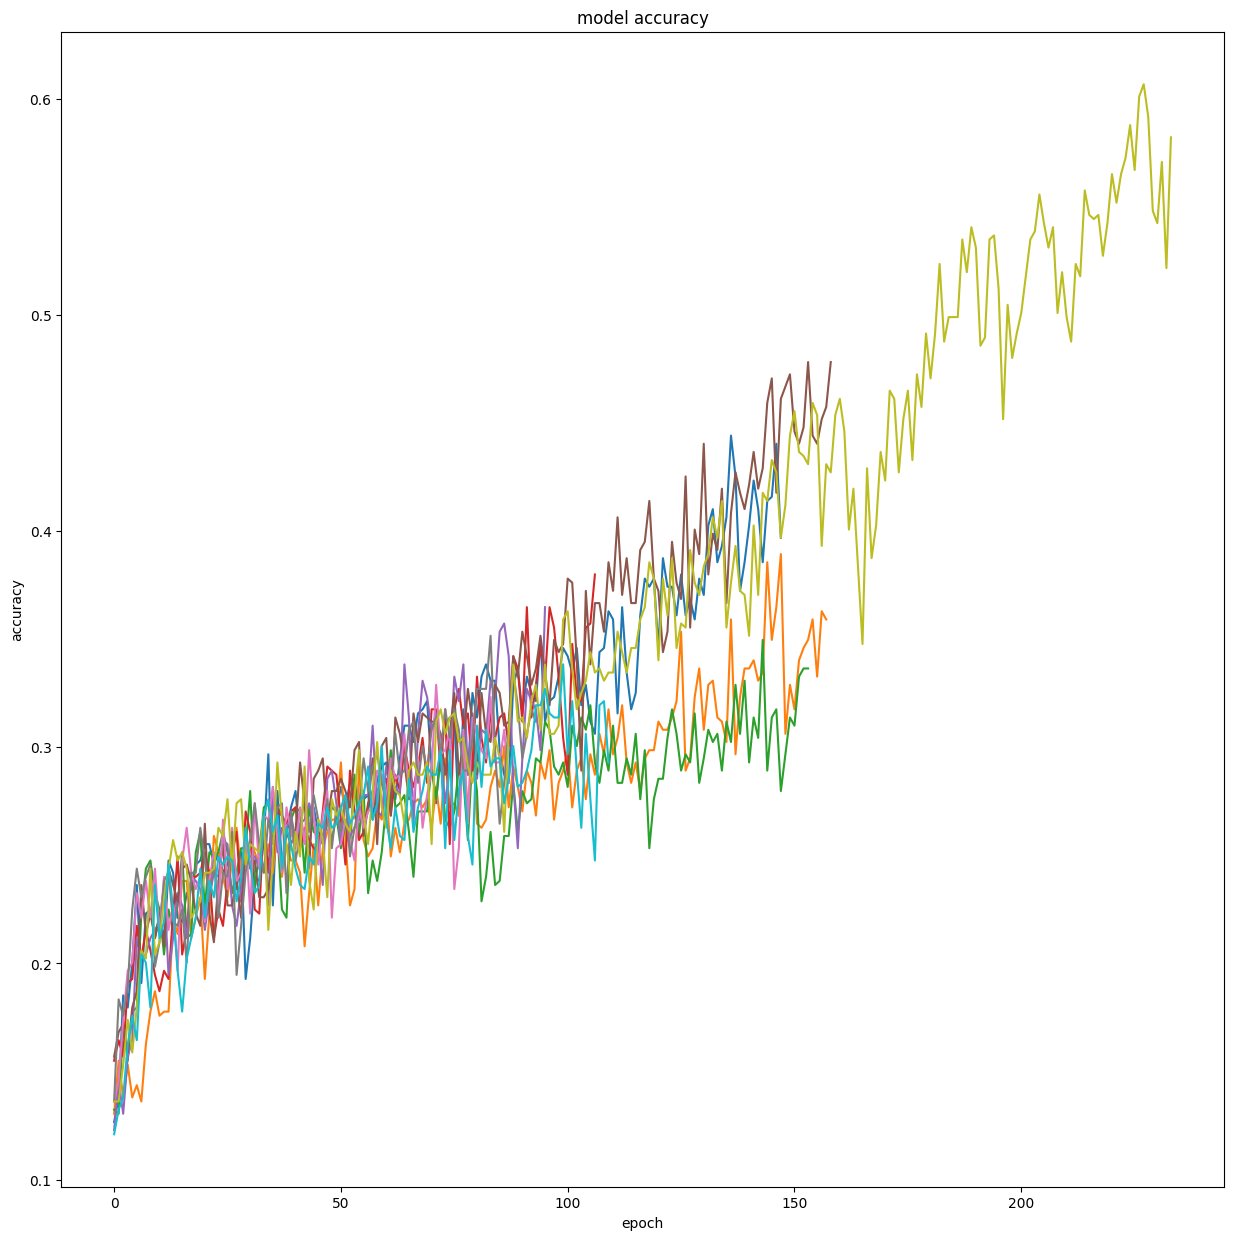

In [124]:
plt.figure(figsize=(15,15))
ax = plt.gca()
cmap = plt.get_cmap('tab10')

for history in (histories_cnn):
    color = cmap(i / len(histories_cnn))
    ax.plot(history.history['accuracy'])
    # ax.plot(history.history['val_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
plt.show()

<Axes: >

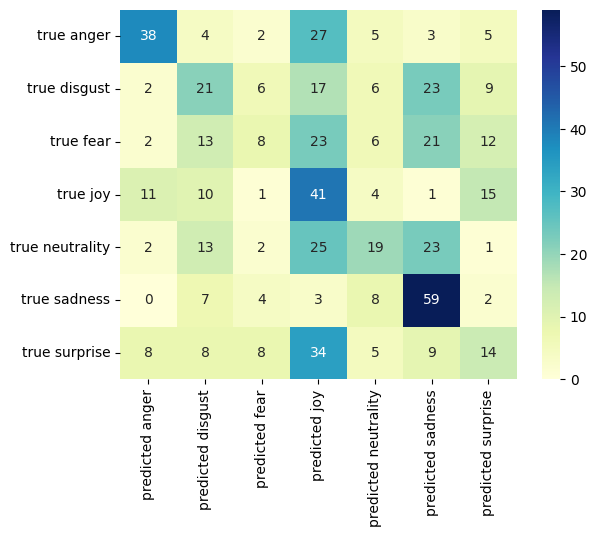

In [125]:
create_confusion_matrix(confusion_matrix(actual_labels_cnn, predicted_labels_cnn))

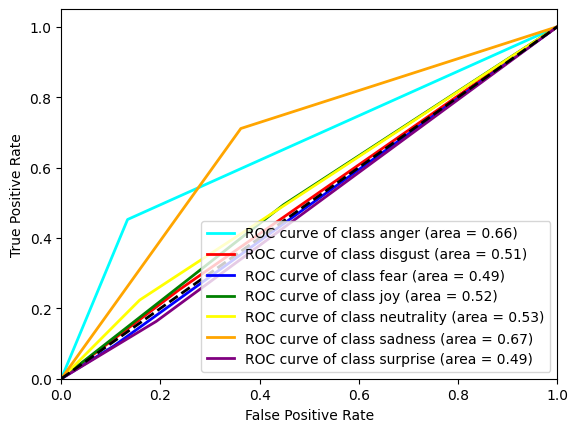

None


precision    recall        f1
anger        0.603175  0.452381  0.517007
disgust      0.276316  0.250000  0.262500
fear         0.258065  0.094118  0.137931
joy          0.241176  0.493976  0.324111
neutrality   0.358491  0.223529  0.275362
sadness      0.424460  0.710843  0.531532
surprise     0.241379  0.162791  0.194444

In [126]:
confus= confusion_matrix(actual_labels_cnn, predicted_labels_cnn)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}

pd.DataFrame(data=macro_dictionary)



In [127]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in results_cnn:
  mean+=i[1]

average_accuracy_cnn= mean/10
print(average_accuracy_cnn)

0.3389830529689789


PERFORMANCE EVALUATION OF CNN - DATA AUGMENTED WITH PITCH SHIFTING




In [ ]:
input_data=(X_logmel_semi_aug.shape[1:])
semi_aug_histories_cnn = []
semi_aug_confusion_matrices_cnn=[]
semi_aug_results_cnn=[]
semi_aug_actual_labels_cnn=np.array([])
semi_aug_predicted_labels_cnn=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_logmel_semi_aug, Y_semi_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
            # get the training and test data
            train_X, test_X = X_logmel_semi_aug[train_indices], X_logmel_semi_aug[test_indices]
            train_y, test_y = Y_semi_aug[train_indices], Y_semi_aug[test_indices]
            semi_aug_actual_labels_cnn=np.append(semi_aug_actual_labels_cnn,test_y)
            #normalize the data
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
            test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
            print(train_X.shape)
            modelcnn=create_cnn(input_data)
            modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=256,epochs=1000,callbacks=[EarlyStopping(patience=15,monitor="loss")])
            semi_aug_histories_cnn.append(history)
            pred=modelcnn.predict(test_X)
            pred=pred.argmax(axis=1)
            semi_aug_predicted_labels_cnn=np.append(semi_aug_predicted_labels_cnn,pred)
            conf_matr=confusion_matrix(test_y,pred)
            semi_aug_confusion_matrices_cnn.append(conf_matr)
            results = modelcnn.evaluate(test_X, test_y, batch_size=128)
            semi_aug_results_cnn.append(results)
            

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 3s 507ms/step - loss: 2.6263 - accuracy: 0.1378 - val_loss: 2.5604 - val_accuracy: 0.1925
Epoch 2/1000
5/5 [==============================] - 1s 123ms/step - loss: 2.5489 - accuracy: 0.1629 - val_loss: 2.5285 - val_accuracy: 0.1660
Epoch 3/1000
5/5 [==============================] - 1s 107ms/step - loss: 2.5002 - accuracy: 0.1872 - val_loss: 2.4839 - val_accuracy: 0.2132
Epoch 4/1000
5/5 [==============================] - 1s 123ms/step - loss: 2.4280 - accuracy: 0.2204 - val_loss: 2.4039 - val_accuracy: 0.2509
Epoch 5/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.3881 - accuracy: 0.2099 - val_loss: 2.3787 - val_accuracy: 0.2623
Epoch 6/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.3212 - accuracy: 0.2188 - val_loss: 2.3420 - val_accuracy: 0.2906
Epoch 7/1000
5/5 [==============================] - 1s 104ms/step - loss: 2.3009 - accuracy: 0.2147 - val_loss: 2.3004 - val_accu

Computing k-fold:  10%|█         | 1/10 [02:29<22:27, 149.73s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 2s 174ms/step - loss: 2.5995 - accuracy: 0.1532 - val_loss: 2.5536 - val_accuracy: 0.1585
Epoch 2/1000
5/5 [==============================] - 1s 104ms/step - loss: 2.5275 - accuracy: 0.1742 - val_loss: 2.5003 - val_accuracy: 0.2094
Epoch 3/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.4463 - accuracy: 0.2066 - val_loss: 2.4026 - val_accuracy: 0.2642
Epoch 4/1000
5/5 [==============================] - 0s 104ms/step - loss: 2.3818 - accuracy: 0.2253 - val_loss: 2.3763 - val_accuracy: 0.2566
Epoch 5/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.3263 - accuracy: 0.2204 - val_loss: 2.3299 - val_accuracy: 0.2585
Epoch 6/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.2794 - accuracy: 0.2382 - val_loss: 2.2789 - val_accuracy: 0.2736
Epoch 7/1000
5/5 [==============================] - 1s 104ms/step - loss: 2.2319 - accuracy: 0.2536 - val_loss: 2.2455 - val_accu

Computing k-fold:  20%|██        | 2/10 [04:53<19:28, 146.04s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 2s 172ms/step - loss: 2.6033 - accuracy: 0.1329 - val_loss: 2.5540 - val_accuracy: 0.2057
Epoch 2/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.5273 - accuracy: 0.1888 - val_loss: 2.5057 - val_accuracy: 0.2509
Epoch 3/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.4512 - accuracy: 0.2464 - val_loss: 2.4232 - val_accuracy: 0.2453
Epoch 4/1000
5/5 [==============================] - 1s 104ms/step - loss: 2.3855 - accuracy: 0.2212 - val_loss: 2.3873 - val_accuracy: 0.2698
Epoch 5/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.3422 - accuracy: 0.2407 - val_loss: 2.3412 - val_accuracy: 0.2566
Epoch 6/1000
5/5 [==============================] - 0s 104ms/step - loss: 2.3146 - accuracy: 0.2285 - val_loss: 2.3150 - val_accuracy: 0.2642
Epoch 7/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.2612 - accuracy: 0.2553 - val_loss: 2.2722 - val_accu

Computing k-fold:  30%|███       | 3/10 [06:33<14:35, 125.00s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 1s 150ms/step - loss: 2.5874 - accuracy: 0.1459 - val_loss: 2.5472 - val_accuracy: 0.1679
Epoch 2/1000
5/5 [==============================] - 1s 123ms/step - loss: 2.5148 - accuracy: 0.1807 - val_loss: 2.4904 - val_accuracy: 0.2113
Epoch 3/1000
5/5 [==============================] - 0s 104ms/step - loss: 2.4377 - accuracy: 0.2034 - val_loss: 2.4228 - val_accuracy: 0.2038
Epoch 4/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.3695 - accuracy: 0.2261 - val_loss: 2.3909 - val_accuracy: 0.2453
Epoch 5/1000
5/5 [==============================] - 1s 124ms/step - loss: 2.3355 - accuracy: 0.2188 - val_loss: 2.3458 - val_accuracy: 0.2642
Epoch 6/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.2734 - accuracy: 0.2520 - val_loss: 2.3061 - val_accuracy: 0.1981
Epoch 7/1000
5/5 [==============================] - 0s 104ms/step - loss: 2.2474 - accuracy: 0.2512 - val_loss: 2.2685 - val_accu

Computing k-fold:  40%|████      | 4/10 [08:56<13:13, 132.28s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 2s 158ms/step - loss: 2.6099 - accuracy: 0.1524 - val_loss: 2.5561 - val_accuracy: 0.1830
Epoch 2/1000
5/5 [==============================] - 0s 102ms/step - loss: 2.5162 - accuracy: 0.2147 - val_loss: 2.5025 - val_accuracy: 0.2415
Epoch 3/1000
5/5 [==============================] - 1s 104ms/step - loss: 2.4328 - accuracy: 0.2391 - val_loss: 2.4231 - val_accuracy: 0.2453
Epoch 4/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.3948 - accuracy: 0.2350 - val_loss: 2.4116 - val_accuracy: 0.2377
Epoch 5/1000
5/5 [==============================] - 1s 103ms/step - loss: 2.3595 - accuracy: 0.2358 - val_loss: 2.3820 - val_accuracy: 0.2245
Epoch 6/1000
5/5 [==============================] - 1s 125ms/step - loss: 2.3003 - accuracy: 0.2496 - val_loss: 2.3319 - val_accuracy: 0.2264
Epoch 7/1000
5/5 [==============================] - 0s 102ms/step - loss: 2.2740 - accuracy: 0.2472 - val_loss: 2.2921 - val_accu

Computing k-fold:  50%|█████     | 5/10 [10:54<10:35, 127.10s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 1s 151ms/step - loss: 2.6100 - accuracy: 0.1515 - val_loss: 2.5543 - val_accuracy: 0.1453
Epoch 2/1000
5/5 [==============================] - 1s 106ms/step - loss: 2.5312 - accuracy: 0.1718 - val_loss: 2.5076 - val_accuracy: 0.1811
Epoch 3/1000
5/5 [==============================] - 1s 106ms/step - loss: 2.4583 - accuracy: 0.2196 - val_loss: 2.4230 - val_accuracy: 0.2566
Epoch 4/1000
5/5 [==============================] - 1s 124ms/step - loss: 2.4057 - accuracy: 0.2107 - val_loss: 2.3731 - val_accuracy: 0.2792
Epoch 5/1000
5/5 [==============================] - 0s 104ms/step - loss: 2.3391 - accuracy: 0.2334 - val_loss: 2.3466 - val_accuracy: 0.2792
Epoch 6/1000
5/5 [==============================] - 1s 125ms/step - loss: 2.3042 - accuracy: 0.2293 - val_loss: 2.2830 - val_accuracy: 0.2755
Epoch 7/1000
5/5 [==============================] - 0s 104ms/step - loss: 2.2624 - accuracy: 0.2415 - val_loss: 2.2751 - val_accu

Computing k-fold:  60%|██████    | 6/10 [12:58<08:23, 125.87s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 2s 154ms/step - loss: 2.5915 - accuracy: 0.1483 - val_loss: 2.5503 - val_accuracy: 0.1434
Epoch 2/1000
5/5 [==============================] - 1s 106ms/step - loss: 2.5161 - accuracy: 0.1985 - val_loss: 2.4927 - val_accuracy: 0.2208
Epoch 3/1000
5/5 [==============================] - 1s 125ms/step - loss: 2.4392 - accuracy: 0.2196 - val_loss: 2.3994 - val_accuracy: 0.2302
Epoch 4/1000
5/5 [==============================] - 1s 124ms/step - loss: 2.3558 - accuracy: 0.2366 - val_loss: 2.3671 - val_accuracy: 0.2491
Epoch 5/1000
5/5 [==============================] - 1s 124ms/step - loss: 2.3106 - accuracy: 0.2310 - val_loss: 2.3290 - val_accuracy: 0.2170
Epoch 6/1000
5/5 [==============================] - 1s 106ms/step - loss: 2.2626 - accuracy: 0.2439 - val_loss: 2.2856 - val_accuracy: 0.2208
Epoch 7/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.2364 - accuracy: 0.2512 - val_loss: 2.2464 - val_accu

Computing k-fold:  70%|███████   | 7/10 [15:52<07:05, 141.78s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 1s 150ms/step - loss: 2.6421 - accuracy: 0.1402 - val_loss: 2.5612 - val_accuracy: 0.2113
Epoch 2/1000
5/5 [==============================] - 1s 107ms/step - loss: 2.5399 - accuracy: 0.1791 - val_loss: 2.5257 - val_accuracy: 0.1792
Epoch 3/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.4883 - accuracy: 0.1961 - val_loss: 2.4652 - val_accuracy: 0.2377
Epoch 4/1000
5/5 [==============================] - 1s 106ms/step - loss: 2.4169 - accuracy: 0.2285 - val_loss: 2.3997 - val_accuracy: 0.2472
Epoch 5/1000
5/5 [==============================] - 1s 106ms/step - loss: 2.3603 - accuracy: 0.2229 - val_loss: 2.3726 - val_accuracy: 0.2660
Epoch 6/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.3348 - accuracy: 0.2301 - val_loss: 2.3302 - val_accuracy: 0.2528
Epoch 7/1000
5/5 [==============================] - 1s 126ms/step - loss: 2.2754 - accuracy: 0.2391 - val_loss: 2.2965 - val_accu

Computing k-fold:  80%|████████  | 8/10 [18:15<04:44, 142.30s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 2s 172ms/step - loss: 2.6117 - accuracy: 0.1402 - val_loss: 2.5573 - val_accuracy: 0.1717
Epoch 2/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.5298 - accuracy: 0.1912 - val_loss: 2.5103 - val_accuracy: 0.1981
Epoch 3/1000
5/5 [==============================] - 0s 103ms/step - loss: 2.4514 - accuracy: 0.2326 - val_loss: 2.4273 - val_accuracy: 0.2283
Epoch 4/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.3884 - accuracy: 0.2301 - val_loss: 2.4013 - val_accuracy: 0.2434
Epoch 5/1000
5/5 [==============================] - 1s 104ms/step - loss: 2.3443 - accuracy: 0.2253 - val_loss: 2.3555 - val_accuracy: 0.2566
Epoch 6/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.2940 - accuracy: 0.2431 - val_loss: 2.3073 - val_accuracy: 0.2415
Epoch 7/1000
5/5 [==============================] - 0s 104ms/step - loss: 2.2493 - accuracy: 0.2634 - val_loss: 2.2795 - val_accu

Computing k-fold:  90%|█████████ | 9/10 [19:25<01:59, 119.59s/it]

(1234, 60, 130, 1)
Epoch 1/1000
5/5 [==============================] - 2s 177ms/step - loss: 2.5967 - accuracy: 0.1548 - val_loss: 2.5526 - val_accuracy: 0.1830
Epoch 2/1000
5/5 [==============================] - 1s 124ms/step - loss: 2.5159 - accuracy: 0.2018 - val_loss: 2.4965 - val_accuracy: 0.2509
Epoch 3/1000
5/5 [==============================] - 1s 125ms/step - loss: 2.4417 - accuracy: 0.2139 - val_loss: 2.4154 - val_accuracy: 0.2604
Epoch 4/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.3674 - accuracy: 0.2407 - val_loss: 2.3904 - val_accuracy: 0.2302
Epoch 5/1000
5/5 [==============================] - 1s 124ms/step - loss: 2.3494 - accuracy: 0.2164 - val_loss: 2.3513 - val_accuracy: 0.2358
Epoch 6/1000
5/5 [==============================] - 1s 105ms/step - loss: 2.2929 - accuracy: 0.2293 - val_loss: 2.3117 - val_accuracy: 0.2717
Epoch 7/1000
5/5 [==============================] - 1s 125ms/step - loss: 2.2612 - accuracy: 0.2382 - val_loss: 2.2773 - val_accu

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

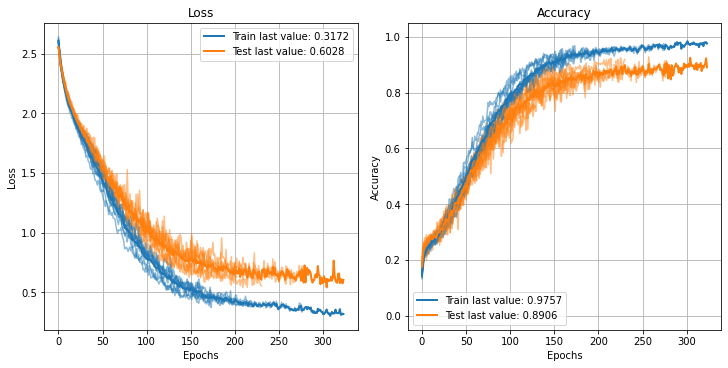

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
#plot model history
show_history(semi_aug_histories_cnn)

plt.close()

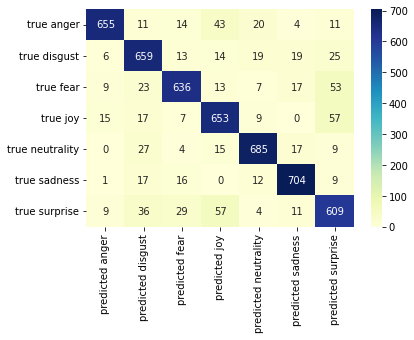

In [ ]:
create_confusion_matrix(confusion_matrix(semi_aug_actual_labels_cnn, semi_aug_predicted_labels_cnn))

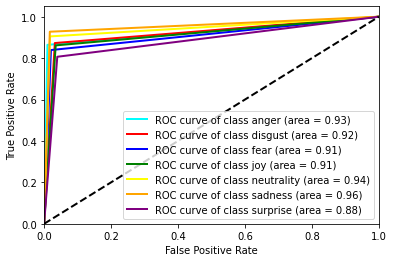

None


precision    recall        f1
anger        0.942446  0.864116  0.901583
disgust      0.834177  0.872848  0.853074
fear         0.884562  0.839050  0.861205
joy          0.821384  0.861478  0.840953
neutrality   0.906085  0.904888  0.905486
sadness      0.911917  0.927536  0.919660
surprise     0.787840  0.806623  0.797120

In [ ]:
confus= confusion_matrix(semi_aug_actual_labels_cnn, semi_aug_predicted_labels_cnn)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}
pd.DataFrame(data=macro_dictionary)

In [ ]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in semi_aug_results_cnn:
  mean+=i[1]

semi_aug_average_accuracy_cnn= mean/10
print(semi_aug_average_accuracy_cnn)

0.8681132078170777


PERFORMANCE EVALUATION OF CNN - DATA AUGMENTED WITH PITCH SHIFTING AND NOISE ADDITION

In [ ]:
input_data=(X_logmel_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_logmel_aug, Y_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
            # get the training and test data
            train_X, test_X = X_logmel_aug[train_indices], X_logmel_aug[test_indices]
            train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
            aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
            #normalize the data
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
            test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
            print(train_X.shape)
            modelcnn=create_cnn(input_data)
            modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=256,epochs=1000,callbacks=[EarlyStopping(patience=20,monitor="loss")])
            aug_histories_cnn.append(history)
            pred=modelcnn.predict(test_X)
            pred=pred.argmax(axis=1)
            aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
            conf_matr=confusion_matrix(test_y,pred)
            aug_confusion_matrices_cnn.append(conf_matr)
            results = modelcnn.evaluate(test_X, test_y, batch_size=128)
            aug_results_cnn.append(results)
  

NameError: ignored

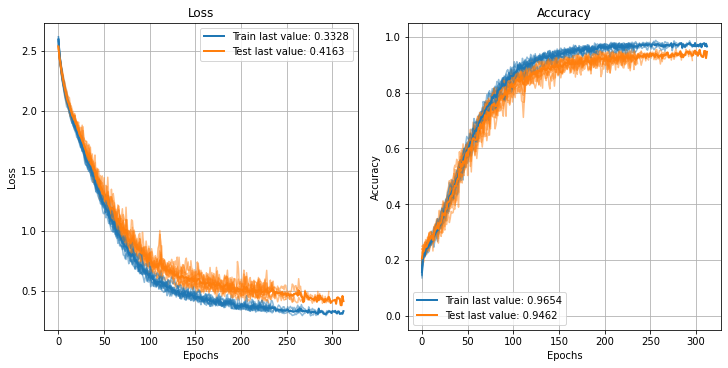

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
#plot the model history 
show_history(aug_histories_cnn)

plt.close()

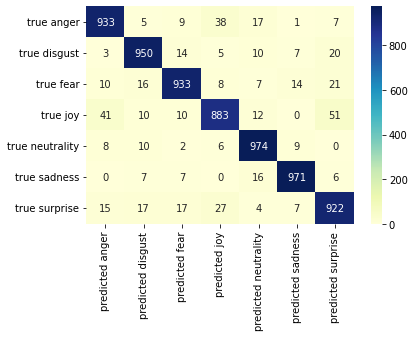

In [ ]:
create_confusion_matrix(confusion_matrix(aug_actual_labels_cnn, aug_predicted_labels_cnn))

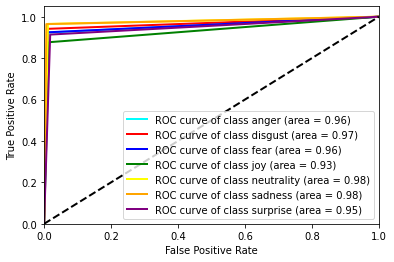

None


precision    recall        f1
anger        0.923762  0.923762  0.923762
disgust      0.935961  0.941526  0.938735
fear         0.940524  0.924678  0.932534
joy          0.913133  0.876862  0.894630
neutrality   0.936538  0.965312  0.950708
sadness      0.962339  0.964250  0.963294
surprise     0.897760  0.913776  0.905697

In [ ]:
confus= confusion_matrix(aug_actual_labels_cnn, aug_predicted_labels_cnn)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}
pd.DataFrame(data=macro_dictionary)

In [ ]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in aug_results_cnn:
  mean+=i[1]

aug_average_accuracy_cnn= mean/10
print(aug_average_accuracy_cnn)

0.9300283193588257


**MULTILAYER PERCEPTRON**

In [ ]:
#create the multilayer perceptron
from keras.layers import ReLU
def create_mlp(): 
  model = keras.Sequential([

    
        keras.layers.Flatten(input_shape=(X_mfccs.shape[1], X_mfccs.shape[2])),
       
        keras.layers.Dense(1024,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
      
   
        keras.layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
       
    
        keras.layers.Dense(256,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

       
        keras.layers.Dense(7, activation='softmax')
    ])

  

  model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  return model


 

PERFORMANCE EVALUATION OF MLP - NON AUGMENTED DATA

In [ ]:
histories_mlp = []
confusion_matrices_mlp=[]
results_mlp=[]
actual_labels_mlp=np.array([])
predicted_labels_mlp=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_mfccs, Y_not_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
          #get the training and test data
          train_X, test_X = X_mfccs[train_indices], X_mfccs[test_indices]
          train_y, test_y = Y_not_aug[train_indices], Y_not_aug[test_indices]
          actual_labels_mlp=np.append(actual_labels_mlp,test_y)
          #normalize the data
          scaler = StandardScaler()
          train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
          test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
          model=create_mlp()
          history=model.fit(train_X, train_y,  validation_data=(test_X,test_y),epochs=500,callbacks=[EarlyStopping(patience=10,monitor="loss")])
          histories_mlp.append(history)
          pred=model.predict(test_X)
          pred=pred.argmax(axis=1)
          predicted_labels_mlp=np.append(predicted_labels_mlp,pred)
          conf_matr=confusion_matrix(test_y,pred)
          confusion_matrices_mlp.append(conf_matr)
          results = model.evaluate(test_X, test_y, batch_size=None)
          results_mlp.append(results)
          

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/500
13/13 [==============================] - 1s 34ms/step - loss: 5.2006 - accuracy: 0.1630 - val_loss: 4.3455 - val_accuracy: 0.1469
Epoch 2/500
13/13 [==============================] - 0s 19ms/step - loss: 4.3469 - accuracy: 0.1849 - val_loss: 3.9012 - val_accuracy: 0.2260
Epoch 3/500
13/13 [==============================] - 0s 21ms/step - loss: 3.9251 - accuracy: 0.1849 - val_loss: 3.7243 - val_accuracy: 0.2542
Epoch 4/500
13/13 [==============================] - 0s 16ms/step - loss: 3.6553 - accuracy: 0.2190 - val_loss: 3.4307 - val_accuracy: 0.2881
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.3238 - accuracy: 0.3187 - val_loss: 3.2791 - val_accuracy: 0.2599
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1519 - accuracy: 0.3066 - val_loss: 3.2162 - val_accuracy: 0.2881
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 3.0428 - accuracy: 0.3479 - val_loss: 3.0224 - val_accuracy: 0.2542
Epoch 8/5

Computing k-fold:  10%|█         | 1/10 [00:14<02:14, 14.89s/it]

Epoch 1/500
13/13 [==============================] - 2s 52ms/step - loss: 5.2231 - accuracy: 0.1314 - val_loss: 4.3023 - val_accuracy: 0.1299
Epoch 2/500
13/13 [==============================] - 0s 11ms/step - loss: 4.3036 - accuracy: 0.1995 - val_loss: 3.9491 - val_accuracy: 0.2034
Epoch 3/500
13/13 [==============================] - 0s 11ms/step - loss: 3.9180 - accuracy: 0.2214 - val_loss: 3.6881 - val_accuracy: 0.2203
Epoch 4/500
13/13 [==============================] - 0s 11ms/step - loss: 3.6309 - accuracy: 0.2652 - val_loss: 3.4389 - val_accuracy: 0.2938
Epoch 5/500
13/13 [==============================] - 0s 19ms/step - loss: 3.3752 - accuracy: 0.2993 - val_loss: 3.2957 - val_accuracy: 0.3220
Epoch 6/500
13/13 [==============================] - 0s 16ms/step - loss: 3.1469 - accuracy: 0.3236 - val_loss: 3.1960 - val_accuracy: 0.2429
Epoch 7/500
13/13 [==============================] - 0s 12ms/step - loss: 2.9967 - accuracy: 0.3479 - val_loss: 3.0544 - val_accuracy: 0.2034
Epoch 

Computing k-fold:  20%|██        | 2/10 [00:32<02:12, 16.54s/it]

Epoch 1/500
13/13 [==============================] - 1s 29ms/step - loss: 5.4456 - accuracy: 0.1192 - val_loss: 4.4073 - val_accuracy: 0.1469
Epoch 2/500
13/13 [==============================] - 0s 10ms/step - loss: 4.4430 - accuracy: 0.1557 - val_loss: 4.0106 - val_accuracy: 0.2373
Epoch 3/500
13/13 [==============================] - 0s 13ms/step - loss: 3.9443 - accuracy: 0.2092 - val_loss: 3.6940 - val_accuracy: 0.2881
Epoch 4/500
13/13 [==============================] - 0s 13ms/step - loss: 3.6533 - accuracy: 0.2263 - val_loss: 3.4418 - val_accuracy: 0.3051
Epoch 5/500
13/13 [==============================] - 0s 11ms/step - loss: 3.3615 - accuracy: 0.3187 - val_loss: 3.2701 - val_accuracy: 0.2825
Epoch 6/500
13/13 [==============================] - 0s 10ms/step - loss: 3.2054 - accuracy: 0.3285 - val_loss: 3.1467 - val_accuracy: 0.2938
Epoch 7/500
13/13 [==============================] - 0s 9ms/step - loss: 3.0335 - accuracy: 0.3504 - val_loss: 3.0271 - val_accuracy: 0.2712
Epoch 8

Computing k-fold:  30%|███       | 3/10 [00:44<01:40, 14.34s/it]

Epoch 1/500
13/13 [==============================] - 1s 21ms/step - loss: 5.3826 - accuracy: 0.1436 - val_loss: 4.3616 - val_accuracy: 0.1356
Epoch 2/500
13/13 [==============================] - 0s 8ms/step - loss: 4.4040 - accuracy: 0.1752 - val_loss: 3.9338 - val_accuracy: 0.2429
Epoch 3/500
13/13 [==============================] - 0s 8ms/step - loss: 3.9197 - accuracy: 0.1922 - val_loss: 3.7089 - val_accuracy: 0.2712
Epoch 4/500
13/13 [==============================] - 0s 8ms/step - loss: 3.6029 - accuracy: 0.2798 - val_loss: 3.4542 - val_accuracy: 0.3277
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.3878 - accuracy: 0.2871 - val_loss: 3.2733 - val_accuracy: 0.2090
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 3.2651 - accuracy: 0.2993 - val_loss: 3.1264 - val_accuracy: 0.2825
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 3.0564 - accuracy: 0.3358 - val_loss: 3.0397 - val_accuracy: 0.2542
Epoch 8/500


Computing k-fold:  40%|████      | 4/10 [00:54<01:15, 12.64s/it]

Epoch 1/500
13/13 [==============================] - 1s 20ms/step - loss: 5.2843 - accuracy: 0.1241 - val_loss: 4.2150 - val_accuracy: 0.2147
Epoch 2/500
13/13 [==============================] - 0s 9ms/step - loss: 4.2452 - accuracy: 0.2117 - val_loss: 3.8898 - val_accuracy: 0.2260
Epoch 3/500
13/13 [==============================] - 0s 7ms/step - loss: 3.8716 - accuracy: 0.2068 - val_loss: 3.5880 - val_accuracy: 0.2655
Epoch 4/500
13/13 [==============================] - 0s 8ms/step - loss: 3.5572 - accuracy: 0.2749 - val_loss: 3.3576 - val_accuracy: 0.3220
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.3497 - accuracy: 0.2482 - val_loss: 3.2122 - val_accuracy: 0.3107
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1343 - accuracy: 0.3358 - val_loss: 3.0665 - val_accuracy: 0.3051
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 2.9927 - accuracy: 0.3114 - val_loss: 3.0782 - val_accuracy: 0.2599
Epoch 8/500


Computing k-fold:  50%|█████     | 5/10 [01:05<01:00, 12.07s/it]

Epoch 1/500
13/13 [==============================] - 1s 20ms/step - loss: 5.2962 - accuracy: 0.1363 - val_loss: 4.3556 - val_accuracy: 0.1299
Epoch 2/500
13/13 [==============================] - 0s 8ms/step - loss: 4.2694 - accuracy: 0.1752 - val_loss: 3.9108 - val_accuracy: 0.2542
Epoch 3/500
13/13 [==============================] - 0s 8ms/step - loss: 3.8912 - accuracy: 0.2044 - val_loss: 3.6343 - val_accuracy: 0.2486
Epoch 4/500
13/13 [==============================] - 0s 8ms/step - loss: 3.5703 - accuracy: 0.2920 - val_loss: 3.4285 - val_accuracy: 0.3785
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.3491 - accuracy: 0.3066 - val_loss: 3.2257 - val_accuracy: 0.3277
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1726 - accuracy: 0.3066 - val_loss: 3.0849 - val_accuracy: 0.3390
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 3.0070 - accuracy: 0.3431 - val_loss: 3.0314 - val_accuracy: 0.2599
Epoch 8/500


Computing k-fold:  60%|██████    | 6/10 [01:23<00:55, 13.97s/it]

Epoch 1/500
13/13 [==============================] - 1s 21ms/step - loss: 5.3041 - accuracy: 0.1387 - val_loss: 4.3083 - val_accuracy: 0.1695
Epoch 2/500
13/13 [==============================] - 0s 8ms/step - loss: 4.2626 - accuracy: 0.1922 - val_loss: 3.9452 - val_accuracy: 0.2203
Epoch 3/500
13/13 [==============================] - 0s 9ms/step - loss: 3.9416 - accuracy: 0.1800 - val_loss: 3.6542 - val_accuracy: 0.2599
Epoch 4/500
13/13 [==============================] - 0s 12ms/step - loss: 3.6566 - accuracy: 0.2336 - val_loss: 3.4063 - val_accuracy: 0.2994
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.3953 - accuracy: 0.2798 - val_loss: 3.1982 - val_accuracy: 0.3277
Epoch 6/500
13/13 [==============================] - 0s 7ms/step - loss: 3.2074 - accuracy: 0.3090 - val_loss: 3.0628 - val_accuracy: 0.3446
Epoch 7/500
13/13 [==============================] - 0s 14ms/step - loss: 3.0459 - accuracy: 0.3382 - val_loss: 2.9600 - val_accuracy: 0.3559
Epoch 8/50

Computing k-fold:  70%|███████   | 7/10 [01:36<00:41, 13.93s/it]

Epoch 1/500
13/13 [==============================] - 1s 35ms/step - loss: 5.2923 - accuracy: 0.1703 - val_loss: 4.3101 - val_accuracy: 0.1299
Epoch 2/500
13/13 [==============================] - 0s 15ms/step - loss: 4.3497 - accuracy: 0.1898 - val_loss: 3.9844 - val_accuracy: 0.1638
Epoch 3/500
13/13 [==============================] - 0s 15ms/step - loss: 3.9404 - accuracy: 0.1873 - val_loss: 3.6844 - val_accuracy: 0.2655
Epoch 4/500
13/13 [==============================] - 0s 14ms/step - loss: 3.6323 - accuracy: 0.2798 - val_loss: 3.4663 - val_accuracy: 0.2655
Epoch 5/500
13/13 [==============================] - 0s 16ms/step - loss: 3.4542 - accuracy: 0.2628 - val_loss: 3.2528 - val_accuracy: 0.2938
Epoch 6/500
13/13 [==============================] - 0s 19ms/step - loss: 3.2014 - accuracy: 0.3260 - val_loss: 3.0989 - val_accuracy: 0.3503
Epoch 7/500
13/13 [==============================] - 0s 14ms/step - loss: 3.0745 - accuracy: 0.3236 - val_loss: 2.9686 - val_accuracy: 0.3220
Epoch 

Computing k-fold:  80%|████████  | 8/10 [01:55<00:31, 15.57s/it]

Epoch 1/500
13/13 [==============================] - 1s 21ms/step - loss: 5.2489 - accuracy: 0.1338 - val_loss: 4.2079 - val_accuracy: 0.1921
Epoch 2/500
13/13 [==============================] - 0s 7ms/step - loss: 4.3384 - accuracy: 0.1727 - val_loss: 3.8572 - val_accuracy: 0.2655
Epoch 3/500
13/13 [==============================] - 0s 9ms/step - loss: 3.8381 - accuracy: 0.2117 - val_loss: 3.6340 - val_accuracy: 0.2542
Epoch 4/500
13/13 [==============================] - 0s 8ms/step - loss: 3.5668 - accuracy: 0.2603 - val_loss: 3.3942 - val_accuracy: 0.2712
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.3109 - accuracy: 0.2774 - val_loss: 3.1688 - val_accuracy: 0.3164
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1354 - accuracy: 0.2895 - val_loss: 3.0312 - val_accuracy: 0.3898
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 3.0086 - accuracy: 0.3163 - val_loss: 2.9915 - val_accuracy: 0.3333
Epoch 8/500


Computing k-fold:  90%|█████████ | 9/10 [02:07<00:14, 14.16s/it]

Epoch 1/500
13/13 [==============================] - 1s 45ms/step - loss: 5.0445 - accuracy: 0.1533 - val_loss: 4.3553 - val_accuracy: 0.1525
Epoch 2/500
13/13 [==============================] - 0s 8ms/step - loss: 4.3252 - accuracy: 0.1995 - val_loss: 3.8572 - val_accuracy: 0.2825
Epoch 3/500
13/13 [==============================] - 0s 8ms/step - loss: 3.8435 - accuracy: 0.2019 - val_loss: 3.5628 - val_accuracy: 0.2825
Epoch 4/500
13/13 [==============================] - 0s 8ms/step - loss: 3.5542 - accuracy: 0.2798 - val_loss: 3.4099 - val_accuracy: 0.3107
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.2981 - accuracy: 0.3090 - val_loss: 3.2111 - val_accuracy: 0.3220
Epoch 6/500
13/13 [==============================] - 0s 9ms/step - loss: 3.1401 - accuracy: 0.3041 - val_loss: 3.0263 - val_accuracy: 0.3446
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 2.9762 - accuracy: 0.3552 - val_loss: 2.9189 - val_accuracy: 0.3220
Epoch 8/500


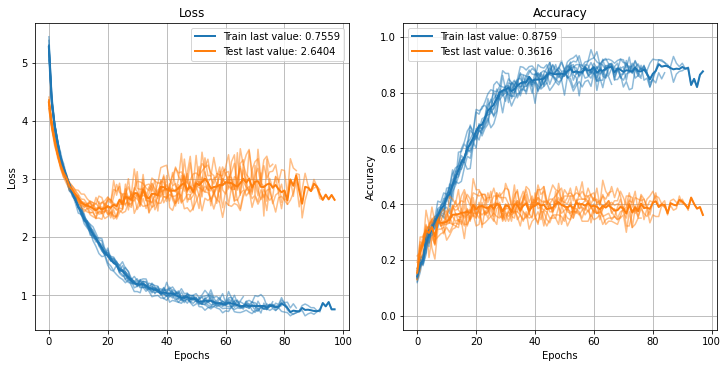

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
#plot model history
show_history(histories_mlp)
plt.close()

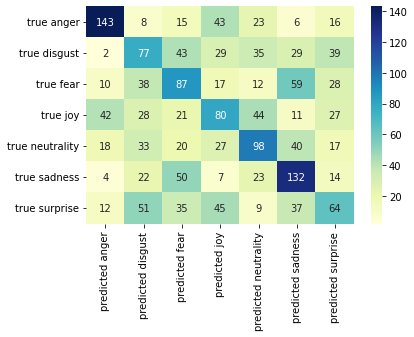

In [ ]:
create_confusion_matrix(confusion_matrix(actual_labels_mlp, predicted_labels_mlp))

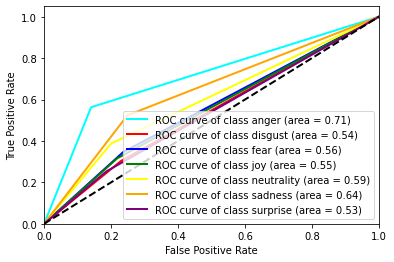

None


precision    recall        f1
anger        0.619048  0.562992  0.589691
disgust      0.299611  0.303150  0.301370
fear         0.321033  0.346614  0.333333
joy          0.322581  0.316206  0.319361
neutrality   0.401639  0.387352  0.394366
sadness      0.420382  0.523810  0.466431
surprise     0.312195  0.252964  0.279476

In [ ]:
confus= confusion_matrix(actual_labels_mlp, predicted_labels_mlp)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}
pd.DataFrame(data=macro_dictionary)

In [ ]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in results_mlp:
  mean+=i[1]

average_accuracy_mlp= mean/10
print(average_accuracy_mlp)

0.3847457617521286


PERFORMANCE EVALUATION OF MLP - DATA AUGMENTED WITH PITCH SHIFTING

In [ ]:
semi_aug_histories_mlp = []
semi_aug_confusion_matrices_mlp=[]
semi_aug_results_mlp=[]
semi_aug_actual_labels_mlp=np.array([])
semi_aug_predicted_labels_mlp=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_mfccs_semi_aug, Y_semi_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
          #get the training and test data
          train_X, test_X = X_mfccs_semi_aug[train_indices], X_mfccs_semi_aug[test_indices]
          train_y, test_y = Y_semi_aug[train_indices], Y_semi_aug[test_indices]
          semi_aug_actual_labels_mlp=np.append(semi_aug_actual_labels_mlp,test_y)
          #normalize the data
          scaler = StandardScaler()
          train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
          test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
          model=create_mlp()
          history=model.fit(train_X, train_y,  validation_data=(test_X,test_y),epochs=500,callbacks=[EarlyStopping(patience=10,monitor="loss")])
          semi_aug_histories_mlp.append(history)
          pred=model.predict(test_X)
          pred=pred.argmax(axis=1)
          semi_aug_predicted_labels_mlp=np.append(semi_aug_predicted_labels_mlp,pred)
          conf_matr=confusion_matrix(test_y,pred)
          semi_aug_confusion_matrices_mlp.append(conf_matr)
          results = model.evaluate(test_X, test_y, batch_size=None)
          semi_aug_results_mlp.append(results)
          

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5379 - accuracy: 0.1880 - val_loss: 3.6855 - val_accuracy: 0.2528
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4893 - accuracy: 0.2512 - val_loss: 3.1515 - val_accuracy: 0.3057
Epoch 3/500
39/39 [==============================] - 0s 6ms/step - loss: 3.0059 - accuracy: 0.3225 - val_loss: 2.8642 - val_accuracy: 0.3208
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 2.6981 - accuracy: 0.3541 - val_loss: 2.5840 - val_accuracy: 0.3528
Epoch 5/500
39/39 [==============================] - 0s 7ms/step - loss: 2.4902 - accuracy: 0.3728 - val_loss: 2.3797 - val_accuracy: 0.4151
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.2480 - accuracy: 0.4279 - val_loss: 2.2521 - val_accuracy: 0.4377
Epoch 7/500
39/39 [==============================] - 0s 7ms/step - loss: 2.0952 - accuracy: 0.4724 - val_loss: 2.2605 - val_accuracy: 0.3925
Epoch 8/500


Computing k-fold:  10%|█         | 1/10 [00:21<03:12, 21.38s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5421 - accuracy: 0.1912 - val_loss: 3.6721 - val_accuracy: 0.2623
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4419 - accuracy: 0.2528 - val_loss: 3.1059 - val_accuracy: 0.3132
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 2.9753 - accuracy: 0.3096 - val_loss: 2.7901 - val_accuracy: 0.3755
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 2.6998 - accuracy: 0.3233 - val_loss: 2.5658 - val_accuracy: 0.3547
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 2.4278 - accuracy: 0.3882 - val_loss: 2.4174 - val_accuracy: 0.3962
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.3205 - accuracy: 0.3995 - val_loss: 2.2978 - val_accuracy: 0.3849
Epoch 7/500
39/39 [==============================] - 0s 6ms/step - loss: 2.1418 - accuracy: 0.4473 - val_loss: 2.1595 - val_accuracy: 0.4547
Epoch 8/500


Computing k-fold:  20%|██        | 2/10 [00:40<02:38, 19.79s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5018 - accuracy: 0.1848 - val_loss: 3.6159 - val_accuracy: 0.2585
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4084 - accuracy: 0.2472 - val_loss: 3.0621 - val_accuracy: 0.3226
Epoch 3/500
39/39 [==============================] - 0s 6ms/step - loss: 2.9597 - accuracy: 0.2966 - val_loss: 2.8121 - val_accuracy: 0.2943
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 2.7256 - accuracy: 0.3039 - val_loss: 2.5313 - val_accuracy: 0.3811
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 2.5028 - accuracy: 0.3525 - val_loss: 2.3671 - val_accuracy: 0.3755
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.3226 - accuracy: 0.3671 - val_loss: 2.2300 - val_accuracy: 0.4113
Epoch 7/500
39/39 [==============================] - 0s 6ms/step - loss: 2.2025 - accuracy: 0.3987 - val_loss: 2.1173 - val_accuracy: 0.4509
Epoch 8/500


Computing k-fold:  30%|███       | 3/10 [00:52<01:56, 16.64s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5121 - accuracy: 0.1710 - val_loss: 3.7085 - val_accuracy: 0.2057
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4322 - accuracy: 0.2650 - val_loss: 3.1502 - val_accuracy: 0.2717
Epoch 3/500
39/39 [==============================] - 0s 6ms/step - loss: 2.9823 - accuracy: 0.3023 - val_loss: 2.8879 - val_accuracy: 0.2849
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 2.6706 - accuracy: 0.3468 - val_loss: 2.5600 - val_accuracy: 0.3566
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 2.4414 - accuracy: 0.3712 - val_loss: 2.4231 - val_accuracy: 0.3906
Epoch 6/500
39/39 [==============================] - 0s 7ms/step - loss: 2.2726 - accuracy: 0.4133 - val_loss: 2.2479 - val_accuracy: 0.4189
Epoch 7/500
39/39 [==============================] - 0s 7ms/step - loss: 2.1713 - accuracy: 0.4117 - val_loss: 2.2295 - val_accuracy: 0.3962
Epoch 8/500


Computing k-fold:  40%|████      | 4/10 [01:34<02:39, 26.61s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5535 - accuracy: 0.1742 - val_loss: 3.6863 - val_accuracy: 0.2132
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4561 - accuracy: 0.2496 - val_loss: 3.1149 - val_accuracy: 0.3113
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 2.9859 - accuracy: 0.3120 - val_loss: 2.8143 - val_accuracy: 0.2981
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 2.6911 - accuracy: 0.3428 - val_loss: 2.5811 - val_accuracy: 0.3377
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 2.4777 - accuracy: 0.3728 - val_loss: 2.4229 - val_accuracy: 0.3321
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.3694 - accuracy: 0.3793 - val_loss: 2.3534 - val_accuracy: 0.3660
Epoch 7/500
39/39 [==============================] - 0s 6ms/step - loss: 2.2116 - accuracy: 0.4125 - val_loss: 2.3270 - val_accuracy: 0.3755
Epoch 8/500


Computing k-fold:  50%|█████     | 5/10 [01:56<02:03, 24.65s/it]

Epoch 1/500
39/39 [==============================] - 1s 11ms/step - loss: 4.4529 - accuracy: 0.1799 - val_loss: 3.6369 - val_accuracy: 0.2981
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4047 - accuracy: 0.2682 - val_loss: 3.0614 - val_accuracy: 0.3264
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 2.9557 - accuracy: 0.3031 - val_loss: 2.7478 - val_accuracy: 0.3491
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 2.6201 - accuracy: 0.3679 - val_loss: 2.5553 - val_accuracy: 0.3642
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 2.4197 - accuracy: 0.3647 - val_loss: 2.3124 - val_accuracy: 0.4113
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.2699 - accuracy: 0.3947 - val_loss: 2.1877 - val_accuracy: 0.4434
Epoch 7/500
39/39 [==============================] - 0s 6ms/step - loss: 2.0910 - accuracy: 0.4465 - val_loss: 2.2067 - val_accuracy: 0.4132
Epoch 8/500


Computing k-fold:  60%|██████    | 6/10 [02:18<01:35, 23.89s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5028 - accuracy: 0.1848 - val_loss: 3.6461 - val_accuracy: 0.2811
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4282 - accuracy: 0.2755 - val_loss: 3.0947 - val_accuracy: 0.3094
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 2.9543 - accuracy: 0.3152 - val_loss: 2.7650 - val_accuracy: 0.4057
Epoch 4/500
39/39 [==============================] - 0s 7ms/step - loss: 2.6679 - accuracy: 0.3476 - val_loss: 2.5190 - val_accuracy: 0.3698
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 2.4732 - accuracy: 0.3760 - val_loss: 2.3530 - val_accuracy: 0.3679
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.2920 - accuracy: 0.4149 - val_loss: 2.2172 - val_accuracy: 0.4283
Epoch 7/500
39/39 [==============================] - 0s 7ms/step - loss: 2.1655 - accuracy: 0.4198 - val_loss: 2.0838 - val_accuracy: 0.4302
Epoch 8/500


Computing k-fold:  70%|███████   | 7/10 [02:40<01:09, 23.29s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5751 - accuracy: 0.1710 - val_loss: 3.7232 - val_accuracy: 0.2849
Epoch 2/500
39/39 [==============================] - 0s 7ms/step - loss: 3.5130 - accuracy: 0.2415 - val_loss: 3.1279 - val_accuracy: 0.3057
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 3.0196 - accuracy: 0.3031 - val_loss: 2.8463 - val_accuracy: 0.3132
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 2.7260 - accuracy: 0.3250 - val_loss: 2.5574 - val_accuracy: 0.3547
Epoch 5/500
39/39 [==============================] - 0s 7ms/step - loss: 2.4917 - accuracy: 0.3606 - val_loss: 2.3440 - val_accuracy: 0.4132
Epoch 6/500
39/39 [==============================] - 0s 7ms/step - loss: 2.3169 - accuracy: 0.4084 - val_loss: 2.2235 - val_accuracy: 0.4283
Epoch 7/500
39/39 [==============================] - 0s 6ms/step - loss: 2.1973 - accuracy: 0.4206 - val_loss: 2.1268 - val_accuracy: 0.4472
Epoch 8/500


Computing k-fold:  80%|████████  | 8/10 [02:52<00:39, 19.79s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5479 - accuracy: 0.1775 - val_loss: 3.6834 - val_accuracy: 0.2208
Epoch 2/500
39/39 [==============================] - 0s 7ms/step - loss: 3.4673 - accuracy: 0.2569 - val_loss: 3.1368 - val_accuracy: 0.3377
Epoch 3/500
39/39 [==============================] - 0s 6ms/step - loss: 2.9884 - accuracy: 0.2990 - val_loss: 2.7287 - val_accuracy: 0.3906
Epoch 4/500
39/39 [==============================] - 0s 7ms/step - loss: 2.7166 - accuracy: 0.3501 - val_loss: 2.5403 - val_accuracy: 0.3698
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 2.5079 - accuracy: 0.3558 - val_loss: 2.4194 - val_accuracy: 0.3792
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.3762 - accuracy: 0.3687 - val_loss: 2.2805 - val_accuracy: 0.4038
Epoch 7/500
39/39 [==============================] - 0s 7ms/step - loss: 2.2139 - accuracy: 0.4360 - val_loss: 2.1504 - val_accuracy: 0.4226
Epoch 8/500


Computing k-fold:  90%|█████████ | 9/10 [03:14<00:20, 20.31s/it]

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 4.5165 - accuracy: 0.1734 - val_loss: 3.6725 - val_accuracy: 0.2472
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 3.4610 - accuracy: 0.2334 - val_loss: 3.1713 - val_accuracy: 0.2453
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 2.9532 - accuracy: 0.3096 - val_loss: 2.7738 - val_accuracy: 0.3340
Epoch 4/500
39/39 [==============================] - 0s 7ms/step - loss: 2.6573 - accuracy: 0.3517 - val_loss: 2.5262 - val_accuracy: 0.3547
Epoch 5/500
39/39 [==============================] - 0s 7ms/step - loss: 2.4717 - accuracy: 0.3590 - val_loss: 2.3115 - val_accuracy: 0.4094
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 2.2948 - accuracy: 0.4011 - val_loss: 2.2674 - val_accuracy: 0.3943
Epoch 7/500
39/39 [==============================] - 0s 6ms/step - loss: 2.1763 - accuracy: 0.4117 - val_loss: 2.1106 - val_accuracy: 0.4396
Epoch 8/500


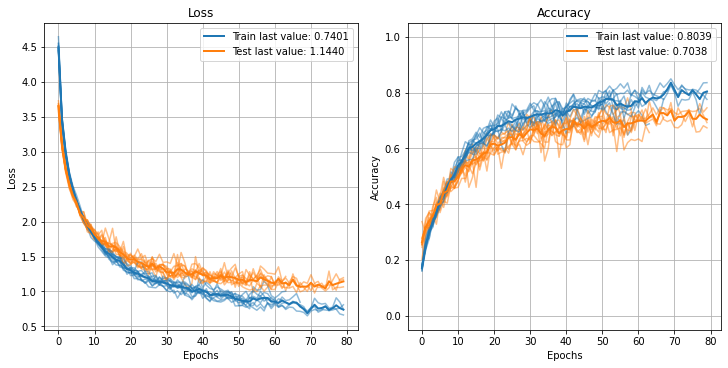

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
#plot model history
show_history(semi_aug_histories_mlp)
plt.close()

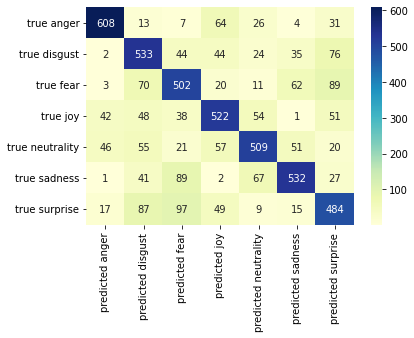

In [ ]:
create_confusion_matrix(confusion_matrix(semi_aug_actual_labels_mlp, semi_aug_predicted_labels_mlp))

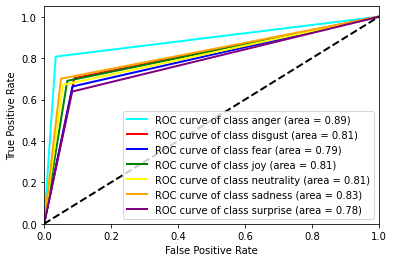

None


precision    recall        f1
anger        0.845619  0.807437  0.826087
disgust      0.629280  0.703166  0.664174
fear         0.629073  0.663144  0.645659
joy          0.688654  0.690476  0.689564
neutrality   0.727143  0.670619  0.697738
sadness      0.760000  0.700922  0.729267
surprise     0.622108  0.638522  0.630208

In [ ]:
confus= confusion_matrix(semi_aug_actual_labels_mlp, semi_aug_predicted_labels_mlp)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}
pd.DataFrame(data=macro_dictionary)

In [ ]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in semi_aug_results_mlp:
  mean+=i[1]

semi_aug_average_accuracy_mlp= mean/10
print(semi_aug_average_accuracy_mlp)

0.6877358496189118


PERFORMANCE EVALUATION OF MLP - DATA AUGMENTED WITH PITCH SHIFTING AND NOISE ADDITION

In [ ]:
aug_histories_mlp = []
aug_confusion_matrices_mlp=[]
aug_results_mlp=[]
aug_actual_labels_mlp=np.array([])
aug_predicted_labels_mlp=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_mfccs_aug, Y_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
          #get the training and test data
          train_X, test_X = X_mfccs_aug[train_indices], X_mfccs_aug[test_indices]
          train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
          aug_actual_labels_mlp=np.append(aug_actual_labels_mlp,test_y)
          #normalize the data
          scaler = StandardScaler()
          train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
          test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
          model=create_mlp()
          history=model.fit(train_X, train_y,  validation_data=(test_X,test_y),epochs=500,callbacks=[EarlyStopping(patience=10,monitor="loss")])
          aug_histories_mlp.append(history)
          pred=model.predict(test_X)
          pred=pred.argmax(axis=1)
          aug_predicted_labels_mlp=np.append(aug_predicted_labels_mlp,pred)
          conf_matr=confusion_matrix(test_y,pred)
          aug_confusion_matrices_mlp.append(conf_matr)
          results = model.evaluate(test_X, test_y, batch_size=None)
          aug_results_mlp.append(results)
          

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/500
52/52 [==============================] - 1s 10ms/step - loss: 4.2576 - accuracy: 0.1902 - val_loss: 3.3972 - val_accuracy: 0.2890
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.1666 - accuracy: 0.2661 - val_loss: 2.8139 - val_accuracy: 0.3654
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7015 - accuracy: 0.3414 - val_loss: 2.5284 - val_accuracy: 0.3343
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.4263 - accuracy: 0.3791 - val_loss: 2.2619 - val_accuracy: 0.4306
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.2007 - accuracy: 0.4137 - val_loss: 2.3895 - val_accuracy: 0.3428
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.1212 - accuracy: 0.4344 - val_loss: 2.0285 - val_accuracy: 0.4646
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 1.9630 - accuracy: 0.4745 - val_loss: 1.9177 - val_accuracy: 0.5099
Epoch 8/500


Computing k-fold:  10%|█         | 1/10 [00:20<03:01, 20.20s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.3601 - accuracy: 0.1750 - val_loss: 3.4997 - val_accuracy: 0.2365
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.2074 - accuracy: 0.2752 - val_loss: 2.8838 - val_accuracy: 0.3343
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7578 - accuracy: 0.3250 - val_loss: 2.5389 - val_accuracy: 0.3839
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.4523 - accuracy: 0.3651 - val_loss: 2.3354 - val_accuracy: 0.4108
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.2710 - accuracy: 0.4083 - val_loss: 2.1518 - val_accuracy: 0.4476
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.1161 - accuracy: 0.4271 - val_loss: 2.0920 - val_accuracy: 0.4221
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 1.9534 - accuracy: 0.4891 - val_loss: 1.8780 - val_accuracy: 0.5113
Epoch 8/500
5

Computing k-fold:  20%|██        | 2/10 [00:39<02:38, 19.80s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.3218 - accuracy: 0.1908 - val_loss: 3.4890 - val_accuracy: 0.2351
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.1929 - accuracy: 0.3007 - val_loss: 2.8669 - val_accuracy: 0.3385
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7324 - accuracy: 0.3360 - val_loss: 2.5625 - val_accuracy: 0.3569
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.4134 - accuracy: 0.3821 - val_loss: 2.3041 - val_accuracy: 0.4164
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.2261 - accuracy: 0.4301 - val_loss: 2.0970 - val_accuracy: 0.4646
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.0524 - accuracy: 0.4502 - val_loss: 2.1578 - val_accuracy: 0.4108
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 1.9373 - accuracy: 0.4903 - val_loss: 1.9871 - val_accuracy: 0.4745
Epoch 8/500
5

Computing k-fold:  30%|███       | 3/10 [01:06<02:40, 22.91s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.2979 - accuracy: 0.2041 - val_loss: 3.4774 - val_accuracy: 0.2762
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.1933 - accuracy: 0.2783 - val_loss: 2.7937 - val_accuracy: 0.3499
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7144 - accuracy: 0.3196 - val_loss: 2.4260 - val_accuracy: 0.4306
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.4181 - accuracy: 0.3864 - val_loss: 2.2253 - val_accuracy: 0.4490
Epoch 5/500
52/52 [==============================] - 0s 7ms/step - loss: 2.2283 - accuracy: 0.4216 - val_loss: 2.1700 - val_accuracy: 0.3980
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.0456 - accuracy: 0.4684 - val_loss: 1.9184 - val_accuracy: 0.5071
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 1.9119 - accuracy: 0.5030 - val_loss: 1.8819 - val_accuracy: 0.5014
Epoch 8/500
5

Computing k-fold:  40%|████      | 4/10 [01:48<03:02, 30.45s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.3308 - accuracy: 0.1950 - val_loss: 3.4923 - val_accuracy: 0.2535
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.2183 - accuracy: 0.2795 - val_loss: 2.8655 - val_accuracy: 0.3215
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7262 - accuracy: 0.3354 - val_loss: 2.5323 - val_accuracy: 0.3584
Epoch 4/500
52/52 [==============================] - 0s 9ms/step - loss: 2.4948 - accuracy: 0.3676 - val_loss: 2.3481 - val_accuracy: 0.3909
Epoch 5/500
52/52 [==============================] - 0s 9ms/step - loss: 2.2434 - accuracy: 0.4137 - val_loss: 2.1232 - val_accuracy: 0.4221
Epoch 6/500
52/52 [==============================] - 0s 8ms/step - loss: 2.0541 - accuracy: 0.4635 - val_loss: 1.9732 - val_accuracy: 0.4788
Epoch 7/500
52/52 [==============================] - 0s 9ms/step - loss: 1.9500 - accuracy: 0.4848 - val_loss: 1.9901 - val_accuracy: 0.4419
Epoch 8/500
5

Computing k-fold:  50%|█████     | 5/10 [02:11<02:18, 27.79s/it]

Epoch 1/500
52/52 [==============================] - 1s 11ms/step - loss: 4.2846 - accuracy: 0.2011 - val_loss: 3.4414 - val_accuracy: 0.3244
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.1638 - accuracy: 0.2861 - val_loss: 2.8381 - val_accuracy: 0.3300
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7369 - accuracy: 0.3360 - val_loss: 2.5281 - val_accuracy: 0.3867
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.4062 - accuracy: 0.3991 - val_loss: 2.2391 - val_accuracy: 0.4547
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.2060 - accuracy: 0.4295 - val_loss: 2.2070 - val_accuracy: 0.4079
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.0393 - accuracy: 0.4714 - val_loss: 2.0126 - val_accuracy: 0.4419
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 1.8817 - accuracy: 0.5267 - val_loss: 1.8863 - val_accuracy: 0.4844
Epoch 8/500


Computing k-fold:  60%|██████    | 6/10 [02:28<01:36, 24.13s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.3746 - accuracy: 0.1835 - val_loss: 3.4773 - val_accuracy: 0.3045
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.2697 - accuracy: 0.2625 - val_loss: 2.8955 - val_accuracy: 0.3470
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.8202 - accuracy: 0.3062 - val_loss: 2.5757 - val_accuracy: 0.3626
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.5095 - accuracy: 0.3688 - val_loss: 2.3742 - val_accuracy: 0.3782
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.2960 - accuracy: 0.4058 - val_loss: 2.1529 - val_accuracy: 0.4462
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.1160 - accuracy: 0.4587 - val_loss: 2.0763 - val_accuracy: 0.4419
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 1.9579 - accuracy: 0.4909 - val_loss: 1.8626 - val_accuracy: 0.5354
Epoch 8/500
5

Computing k-fold:  70%|███████   | 7/10 [02:50<01:10, 23.43s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.2834 - accuracy: 0.1987 - val_loss: 3.4010 - val_accuracy: 0.2989
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.1853 - accuracy: 0.2776 - val_loss: 2.8245 - val_accuracy: 0.3569
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7441 - accuracy: 0.3135 - val_loss: 2.5670 - val_accuracy: 0.3499
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.4717 - accuracy: 0.3663 - val_loss: 2.2468 - val_accuracy: 0.4419
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.2698 - accuracy: 0.3943 - val_loss: 2.0980 - val_accuracy: 0.4830
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.0777 - accuracy: 0.4441 - val_loss: 2.0016 - val_accuracy: 0.4589
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 1.9582 - accuracy: 0.4721 - val_loss: 1.8355 - val_accuracy: 0.5212
Epoch 8/500
5

Computing k-fold:  80%|████████  | 8/10 [03:05<00:41, 20.82s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.3002 - accuracy: 0.2017 - val_loss: 3.4239 - val_accuracy: 0.2776
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.2309 - accuracy: 0.2764 - val_loss: 2.8780 - val_accuracy: 0.3584
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.7794 - accuracy: 0.3287 - val_loss: 2.5561 - val_accuracy: 0.3782
Epoch 4/500
52/52 [==============================] - 0s 8ms/step - loss: 2.4869 - accuracy: 0.3657 - val_loss: 2.3210 - val_accuracy: 0.4391
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.2783 - accuracy: 0.3973 - val_loss: 2.2305 - val_accuracy: 0.3980
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.1473 - accuracy: 0.4174 - val_loss: 2.1063 - val_accuracy: 0.3938
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 2.0002 - accuracy: 0.4617 - val_loss: 1.9318 - val_accuracy: 0.4745
Epoch 8/500
5

Computing k-fold:  90%|█████████ | 9/10 [03:27<00:21, 21.05s/it]

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4.3943 - accuracy: 0.1774 - val_loss: 3.5018 - val_accuracy: 0.3003
Epoch 2/500
52/52 [==============================] - 0s 6ms/step - loss: 3.2831 - accuracy: 0.2643 - val_loss: 2.9377 - val_accuracy: 0.3484
Epoch 3/500
52/52 [==============================] - 0s 6ms/step - loss: 2.8016 - accuracy: 0.3123 - val_loss: 2.5713 - val_accuracy: 0.3853
Epoch 4/500
52/52 [==============================] - 0s 6ms/step - loss: 2.5197 - accuracy: 0.3481 - val_loss: 2.3424 - val_accuracy: 0.4108
Epoch 5/500
52/52 [==============================] - 0s 6ms/step - loss: 2.3144 - accuracy: 0.3937 - val_loss: 2.1623 - val_accuracy: 0.4504
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 2.1243 - accuracy: 0.4222 - val_loss: 2.0845 - val_accuracy: 0.4348
Epoch 7/500
52/52 [==============================] - 0s 6ms/step - loss: 2.0083 - accuracy: 0.4635 - val_loss: 1.8939 - val_accuracy: 0.5170
Epoch 8/500
5

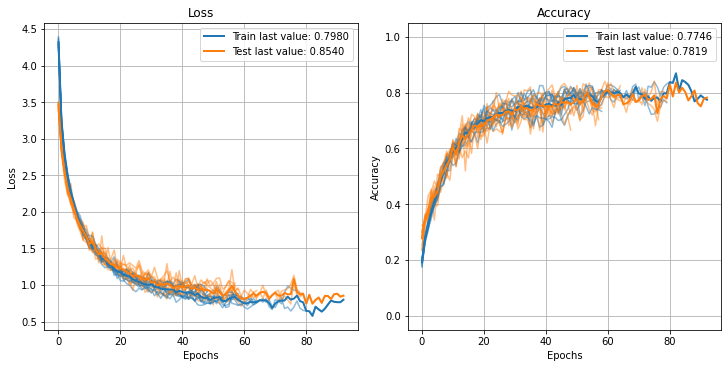

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
#plot model history
show_history(aug_histories_mlp)
plt.close()

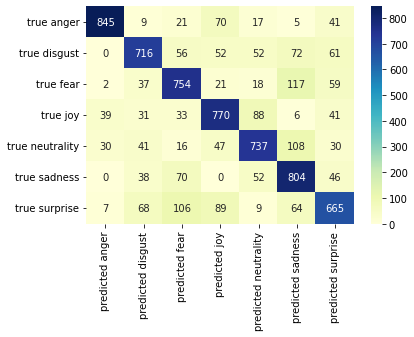

In [ ]:
create_confusion_matrix(confusion_matrix(aug_actual_labels_mlp, aug_predicted_labels_mlp))

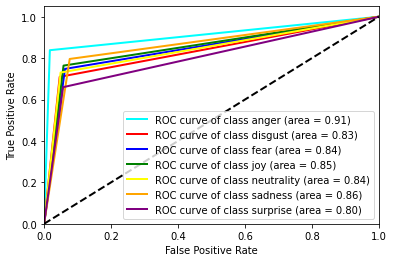

None


precision    recall        f1
anger        0.915493  0.838294  0.875194
disgust      0.761702  0.709613  0.734736
fear         0.714015  0.748016  0.730620
joy          0.734032  0.763889  0.748663
neutrality   0.757451  0.730426  0.743693
sadness      0.683673  0.796040  0.735590
surprise     0.705196  0.659722  0.681702

In [ ]:
confus= confusion_matrix(aug_actual_labels_mlp, aug_predicted_labels_mlp)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}
pd.DataFrame(data=macro_dictionary)

In [ ]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in aug_results_mlp:
  mean+=i[1]

aug_average_accuracy_mlp= mean/10
print(aug_average_accuracy_mlp)

0.749433434009552


#CNN WITH LEAVE-ONE-SPEAKER-OUT

In [ ]:
def create_loso_generator(df,actor):
  train_data=df.index[df['actor'] != actor]
  test_data=df.index[df['actor'] == actor]
  return train_data,test_data



In [ ]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()


  modelcnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_data,kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2,2),padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))
  
  modelcnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  modelcnn.add(keras.layers.MaxPooling2D((3,3),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  modelcnn.add(keras.layers.MaxPooling2D((3, 3),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))

 

  

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  modelcnn.add(keras.layers.Dropout(0.3))
  modelcnn.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  modelcnn.add(keras.layers.Dropout(0.3))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

In [ ]:
input_data=(X_logmel_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
actors=['f1','f2','f3','m1','m2','m3']
for i in tqdm(actors,total=6, leave=False,desc="Computing k-fold"):
  train_indices,test_indices= create_loso_generator(aug_df,i)
  # get the training and test data
  train_X, test_X = X_logmel_aug[train_indices], X_logmel_aug[test_indices]
  train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
  aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
  #normalize the data
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
  test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
  print(train_X.shape)
  modelcnn=create_cnn(input_data)
  modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=128,epochs=1000,callbacks=[EarlyStopping(patience=30,monitor="loss")])
  aug_histories_cnn.append(history)
  pred=modelcnn.predict(test_X)
  pred=pred.argmax(axis=1)
  aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
  conf_matr=confusion_matrix(test_y,pred)
  aug_confusion_matrices_cnn.append(conf_matr)
  results = modelcnn.evaluate(test_X, test_y, batch_size=128)
  aug_results_cnn.append({i: results})

Computing k-fold:   0%|          | 0/6 [00:00<?, ?it/s]

(1960, 60, 130, 1)
Epoch 1/1000
16/16 [==============================] - 3s 56ms/step - loss: 5.9397 - accuracy: 0.1566 - val_loss: 4.8875 - val_accuracy: 0.1837
Epoch 2/1000
16/16 [==============================] - 1s 39ms/step - loss: 4.2438 - accuracy: 0.1704 - val_loss: 3.6197 - val_accuracy: 0.1913
Epoch 3/1000
16/16 [==============================] - 1s 39ms/step - loss: 3.2648 - accuracy: 0.2000 - val_loss: 2.9724 - val_accuracy: 0.2219
Epoch 4/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.7735 - accuracy: 0.2117 - val_loss: 2.6115 - val_accuracy: 0.2270
Epoch 5/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.4849 - accuracy: 0.2184 - val_loss: 2.4048 - val_accuracy: 0.2500
Epoch 6/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.3095 - accuracy: 0.2342 - val_loss: 2.2923 - val_accuracy: 0.2143
Epoch 7/1000
16/16 [==============================] - 1s 39ms/step - loss: 2.1943 - accuracy: 0.2372 - val_loss: 2.1784 - v

Computing k-fold:  17%|█▋        | 1/6 [02:24<12:00, 144.18s/it]

(1960, 60, 130, 1)
Epoch 1/1000
16/16 [==============================] - 3s 56ms/step - loss: 5.8861 - accuracy: 0.1724 - val_loss: 4.8375 - val_accuracy: 0.2092
Epoch 2/1000
16/16 [==============================] - 1s 37ms/step - loss: 4.1912 - accuracy: 0.2168 - val_loss: 3.6437 - val_accuracy: 0.1429
Epoch 3/1000
16/16 [==============================] - 1s 37ms/step - loss: 3.2588 - accuracy: 0.2347 - val_loss: 3.0397 - val_accuracy: 0.1531
Epoch 4/1000
16/16 [==============================] - 1s 36ms/step - loss: 2.7705 - accuracy: 0.2301 - val_loss: 2.6968 - val_accuracy: 0.1633
Epoch 5/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.4914 - accuracy: 0.2495 - val_loss: 2.5663 - val_accuracy: 0.1429
Epoch 6/1000
16/16 [==============================] - 1s 39ms/step - loss: 2.2897 - accuracy: 0.2781 - val_loss: 2.3590 - val_accuracy: 0.1684
Epoch 7/1000
16/16 [==============================] - 1s 38ms/step - loss: 2.1940 - accuracy: 0.2648 - val_loss: 2.6115 - v

Computing k-fold:  33%|███▎      | 2/6 [04:15<08:19, 124.83s/it]

(1960, 60, 130, 1)
Epoch 1/1000
16/16 [==============================] - 3s 54ms/step - loss: 5.8663 - accuracy: 0.1653 - val_loss: 4.7558 - val_accuracy: 0.2245
Epoch 2/1000
16/16 [==============================] - 1s 37ms/step - loss: 4.1121 - accuracy: 0.1923 - val_loss: 3.4956 - val_accuracy: 0.2041
Epoch 3/1000
16/16 [==============================] - 1s 38ms/step - loss: 3.1784 - accuracy: 0.2133 - val_loss: 2.8920 - val_accuracy: 0.1888
Epoch 4/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.7236 - accuracy: 0.2173 - val_loss: 2.5744 - val_accuracy: 0.1964
Epoch 5/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.4601 - accuracy: 0.2296 - val_loss: 2.3104 - val_accuracy: 0.2908
Epoch 6/1000
16/16 [==============================] - 1s 39ms/step - loss: 2.3058 - accuracy: 0.2464 - val_loss: 2.3195 - val_accuracy: 0.1454
Epoch 7/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.2099 - accuracy: 0.2281 - val_loss: 2.1278 - v

Computing k-fold:  50%|█████     | 3/6 [08:38<09:23, 187.82s/it]

(1960, 60, 130, 1)
Epoch 1/1000
16/16 [==============================] - 4s 68ms/step - loss: 5.9452 - accuracy: 0.1464 - val_loss: 4.8778 - val_accuracy: 0.2730
Epoch 2/1000
16/16 [==============================] - 1s 42ms/step - loss: 4.2375 - accuracy: 0.1832 - val_loss: 3.5966 - val_accuracy: 0.2347
Epoch 3/1000
16/16 [==============================] - 1s 40ms/step - loss: 3.2497 - accuracy: 0.1934 - val_loss: 2.8823 - val_accuracy: 0.2577
Epoch 4/1000
16/16 [==============================] - 1s 39ms/step - loss: 2.7570 - accuracy: 0.2153 - val_loss: 2.5570 - val_accuracy: 0.2679
Epoch 5/1000
16/16 [==============================] - 1s 39ms/step - loss: 2.4744 - accuracy: 0.2250 - val_loss: 2.3976 - val_accuracy: 0.2270
Epoch 6/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.3187 - accuracy: 0.2224 - val_loss: 2.2049 - val_accuracy: 0.2704
Epoch 7/1000
16/16 [==============================] - 1s 37ms/step - loss: 2.1869 - accuracy: 0.2281 - val_loss: 2.1310 - v

KeyboardInterrupt: ignored

In [ ]:
print(aug_results_cnn[2]['f3'][1])


0.38265305757522583


#GENRE BASED VALIDATION

In [ ]:
# if genre is male, train on the 3 male speakers and test on the 3 female speakers, if genre is female train on the 3 female speakers and test on the three male speakers
def genre_generator(df,genre):
  if genre=="male":
      train_data=df.index[(df['actor'] == 'm1') | (df['actor'] == 'm2')| (df['actor'] == 'm3')]
      test_data=df.index[(df['actor'] == 'f1') | (df['actor'] == 'f2') | (df['actor'] == 'f3')]
      return train_data,test_data
  else:
      train_data=df.index[(df['actor'] == 'f1') | (df['actor'] == 'f2') | (df['actor'] == 'f3')]
      test_data=df.index[(df['actor'] == 'm1') | (df['actor'] == 'm2') | (df['actor'] == 'm3')]
      return train_data,test_data


In [ ]:
#test on the indicated male speaker and train on the other two male speakers
def male_generator(df,actor):
  train_data=df.index[(df['actor'] != actor) & (df['actor'] != 'f1') & (df['actor'] != 'f2') & (df['actor'] != 'f3')]
  test_data=df.index[df['actor'] == actor]
  return train_data,test_data
  

In [ ]:
#test on the indicated female speaker and train on the other two female speakers
def female_generator(df,actor):
  train_data=df.index[(df['actor'] != actor) & (df['actor'] != 'm1') & (df['actor'] != 'm2') & (df['actor'] != 'm3')]
  test_data=df.index[df['actor'] == actor]
  return train_data,test_data

In [ ]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()


  modelcnn.add(keras.layers.Conv2D(32, (3, 6), activation='relu', input_shape=input_data,kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3, 7), strides=(2,2),padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))
  
  modelcnn.add(keras.layers.Conv2D(64, (3, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3,7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(128, (3, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(256, (3, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))
  modelcnn.add(keras.layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

In [ ]:
# train on the female speakers and test on the male and vice versa
input_data=(X_logmel_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
genres=['male','female']
for i in tqdm(genres,total=2, leave=False,desc="Computing genres"):
  train_indices,test_indices= genre_generator(aug_df,i)
  # get the training and test data
  train_X, test_X = X_logmel_aug[train_indices], X_logmel_aug[test_indices]
  train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
  aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
  #normalize the data
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
  test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
  print(train_X.shape)
  modelcnn=create_cnn(input_data)
  modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=128,epochs=1000,callbacks=[EarlyStopping(patience=30,monitor="loss")])
  aug_histories_cnn.append(history)
  pred=modelcnn.predict(test_X)
  pred=pred.argmax(axis=1)
  aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
  conf_matr=confusion_matrix(test_y,pred)
  aug_confusion_matrices_cnn.append(conf_matr)
  results = modelcnn.evaluate(test_X, test_y, batch_size=128)
  aug_results_cnn.append({i: results})

Computing genres:   0%|          | 0/2 [00:00<?, ?it/s]

(1176, 60, 130, 1)
Epoch 1/1000
10/10 [==============================] - 14s 111ms/step - loss: 2.6119 - accuracy: 0.1488 - val_loss: 2.5470 - val_accuracy: 0.1752
Epoch 2/1000
10/10 [==============================] - 1s 57ms/step - loss: 2.4889 - accuracy: 0.2066 - val_loss: 2.4790 - val_accuracy: 0.2219
Epoch 3/1000
10/10 [==============================] - 1s 61ms/step - loss: 2.3767 - accuracy: 0.2347 - val_loss: 2.4174 - val_accuracy: 0.1658
Epoch 4/1000
10/10 [==============================] - 1s 60ms/step - loss: 2.3069 - accuracy: 0.2313 - val_loss: 2.3912 - val_accuracy: 0.2372
Epoch 5/1000
10/10 [==============================] - 1s 63ms/step - loss: 2.2322 - accuracy: 0.2577 - val_loss: 2.3443 - val_accuracy: 0.2100
Epoch 6/1000
10/10 [==============================] - 1s 63ms/step - loss: 2.1497 - accuracy: 0.2611 - val_loss: 2.3117 - val_accuracy: 0.2313
Epoch 7/1000
10/10 [==============================] - 1s 63ms/step - loss: 2.0759 - accuracy: 0.2891 - val_loss: 2.3547 -

Computing genres:  50%|█████     | 1/2 [03:28<03:28, 208.80s/it]

(1176, 60, 130, 1)
Epoch 1/1000
10/10 [==============================] - 4s 116ms/step - loss: 2.6041 - accuracy: 0.1616 - val_loss: 2.5414 - val_accuracy: 0.1437
Epoch 2/1000
10/10 [==============================] - 1s 64ms/step - loss: 2.4748 - accuracy: 0.2211 - val_loss: 2.4394 - val_accuracy: 0.2296
Epoch 3/1000
10/10 [==============================] - 1s 67ms/step - loss: 2.3608 - accuracy: 0.2236 - val_loss: 2.3993 - val_accuracy: 0.2832
Epoch 4/1000
10/10 [==============================] - 1s 67ms/step - loss: 2.2785 - accuracy: 0.2219 - val_loss: 2.3488 - val_accuracy: 0.2228
Epoch 5/1000
10/10 [==============================] - 1s 60ms/step - loss: 2.2190 - accuracy: 0.2355 - val_loss: 2.3108 - val_accuracy: 0.2526
Epoch 6/1000
10/10 [==============================] - 1s 61ms/step - loss: 2.1578 - accuracy: 0.2577 - val_loss: 2.2799 - val_accuracy: 0.2594
Epoch 7/1000
10/10 [==============================] - 1s 62ms/step - loss: 2.1052 - accuracy: 0.2679 - val_loss: 2.2614 - 

In [ ]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()


  modelcnn.add(keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=input_data,kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 3), strides=(2,2),padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))
  
  modelcnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3,3),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(64, (2, 2), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3, 3),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(128, (2, 2), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((3, 3),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))
  modelcnn.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

In [ ]:
#train and test on male speakers
input_data=(X_logmel_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
actors=['m1','m2','m3']
for i in tqdm(actors,total=3, leave=False,desc="Computing male actors"):
  train_indices,test_indices= male_generator(aug_df,i)
  # get the training and test data
  train_X, test_X = X_logmel_aug[train_indices], X_logmel_aug[test_indices]
  train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
  aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
  #normalize the data
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
  test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
  print(train_X.shape)
  modelcnn=create_cnn(input_data)
  modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=64,epochs=1000,callbacks=[EarlyStopping(patience=10,monitor="loss")])
  aug_histories_cnn.append(history)
  pred=modelcnn.predict(test_X)
  pred=pred.argmax(axis=1)
  aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
  conf_matr=confusion_matrix(test_y,pred)
  aug_confusion_matrices_cnn.append(conf_matr)
  results = modelcnn.evaluate(test_X, test_y, batch_size=128)
  aug_results_cnn.append({i: results})

Computing male actors:   0%|          | 0/3 [00:00<?, ?it/s]

(784, 60, 130, 1)
Epoch 1/1000
13/13 [==============================] - 6s 184ms/step - loss: 2.1984 - accuracy: 0.1658 - val_loss: 2.1738 - val_accuracy: 0.1429
Epoch 2/1000
13/13 [==============================] - 0s 37ms/step - loss: 2.1729 - accuracy: 0.1250 - val_loss: 2.1604 - val_accuracy: 0.1429
Epoch 3/1000
13/13 [==============================] - 1s 48ms/step - loss: 2.1410 - accuracy: 0.1964 - val_loss: 2.1449 - val_accuracy: 0.1429
Epoch 4/1000
13/13 [==============================] - 0s 26ms/step - loss: 2.1017 - accuracy: 0.2181 - val_loss: 2.1283 - val_accuracy: 0.1505
Epoch 5/1000
13/13 [==============================] - 0s 23ms/step - loss: 2.0638 - accuracy: 0.2105 - val_loss: 2.1158 - val_accuracy: 0.1505
Epoch 6/1000
13/13 [==============================] - 0s 19ms/step - loss: 2.0318 - accuracy: 0.2130 - val_loss: 2.1111 - val_accuracy: 0.1429
Epoch 7/1000
13/13 [==============================] - 0s 17ms/step - loss: 1.9867 - accuracy: 0.2309 - val_loss: 2.1037 - v

Computing male actors:  33%|███▎      | 1/3 [00:42<01:25, 42.90s/it]

(784, 60, 130, 1)
Epoch 1/1000
13/13 [==============================] - 3s 48ms/step - loss: 2.1954 - accuracy: 0.1339 - val_loss: 2.1722 - val_accuracy: 0.1429
Epoch 2/1000
13/13 [==============================] - 0s 21ms/step - loss: 2.1628 - accuracy: 0.1518 - val_loss: 2.1566 - val_accuracy: 0.1480
Epoch 3/1000
13/13 [==============================] - 0s 23ms/step - loss: 2.1457 - accuracy: 0.1735 - val_loss: 2.1400 - val_accuracy: 0.1709
Epoch 4/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.1315 - accuracy: 0.1645 - val_loss: 2.1249 - val_accuracy: 0.1735
Epoch 5/1000
13/13 [==============================] - 0s 20ms/step - loss: 2.1056 - accuracy: 0.1990 - val_loss: 2.1101 - val_accuracy: 0.1888
Epoch 6/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.0763 - accuracy: 0.2130 - val_loss: 2.1012 - val_accuracy: 0.2015
Epoch 7/1000
13/13 [==============================] - 0s 19ms/step - loss: 2.0630 - accuracy: 0.1913 - val_loss: 2.0924 - va

Computing male actors:  67%|██████▋   | 2/3 [01:25<00:42, 42.78s/it]

(784, 60, 130, 1)
Epoch 1/1000
13/13 [==============================] - 16s 37ms/step - loss: 2.2093 - accuracy: 0.1480 - val_loss: 2.1766 - val_accuracy: 0.1429
Epoch 2/1000
13/13 [==============================] - 0s 20ms/step - loss: 2.1594 - accuracy: 0.1837 - val_loss: 2.1578 - val_accuracy: 0.1556
Epoch 3/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.1434 - accuracy: 0.1849 - val_loss: 2.1388 - val_accuracy: 0.1454
Epoch 4/1000
13/13 [==============================] - 0s 15ms/step - loss: 2.1081 - accuracy: 0.1773 - val_loss: 2.1221 - val_accuracy: 0.1760
Epoch 5/1000
13/13 [==============================] - 0s 15ms/step - loss: 2.0694 - accuracy: 0.2015 - val_loss: 2.0986 - val_accuracy: 0.1735
Epoch 6/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.0293 - accuracy: 0.2283 - val_loss: 2.0797 - val_accuracy: 0.1556
Epoch 7/1000
13/13 [==============================] - 0s 18ms/step - loss: 1.9795 - accuracy: 0.2283 - val_loss: 2.0689 - v

In [ ]:
#train and test on female speakers
input_data=(X_logmel_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
actors=['f1','f2','f3']
for i in tqdm(actors,total=3, leave=False,desc="Computing female actors"):
  train_indices,test_indices= female_generator(aug_df,i)
  # get the training and test data
  train_X, test_X = X_logmel_aug[train_indices], X_logmel_aug[test_indices]
  train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
  aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
  #normalize the data
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
  test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
  print(train_X.shape)
  modelcnn=create_cnn(input_data)
  modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=64,epochs=1000,callbacks=[EarlyStopping(patience=20,monitor="loss")])
  aug_histories_cnn.append(history)
  pred=modelcnn.predict(test_X)
  pred=pred.argmax(axis=1)
  aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
  conf_matr=confusion_matrix(test_y,pred)
  aug_confusion_matrices_cnn.append(conf_matr)
  results = modelcnn.evaluate(test_X, test_y, batch_size=128)
  aug_results_cnn.append({i: results})

Computing female actors:   0%|          | 0/3 [00:00<?, ?it/s]

(784, 60, 130, 1)
Epoch 1/1000
13/13 [==============================] - 5s 57ms/step - loss: 2.2124 - accuracy: 0.1352 - val_loss: 2.1797 - val_accuracy: 0.1429
Epoch 2/1000
13/13 [==============================] - 0s 20ms/step - loss: 2.1756 - accuracy: 0.1314 - val_loss: 2.1635 - val_accuracy: 0.2015
Epoch 3/1000
13/13 [==============================] - 0s 22ms/step - loss: 2.1520 - accuracy: 0.1709 - val_loss: 2.1426 - val_accuracy: 0.2117
Epoch 4/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.1309 - accuracy: 0.1543 - val_loss: 2.1172 - val_accuracy: 0.2347
Epoch 5/1000
13/13 [==============================] - 0s 17ms/step - loss: 2.0959 - accuracy: 0.1824 - val_loss: 2.0861 - val_accuracy: 0.2679
Epoch 6/1000
13/13 [==============================] - 0s 20ms/step - loss: 2.0627 - accuracy: 0.1901 - val_loss: 2.0628 - val_accuracy: 0.2730
Epoch 7/1000
13/13 [==============================] - 0s 20ms/step - loss: 2.0300 - accuracy: 0.2054 - val_loss: 2.0551 - va

Computing female actors:  33%|███▎      | 1/3 [01:06<02:12, 66.18s/it]

(784, 60, 130, 1)
Epoch 1/1000
13/13 [==============================] - 3s 38ms/step - loss: 2.1990 - accuracy: 0.1429 - val_loss: 2.1744 - val_accuracy: 0.1582
Epoch 2/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.1694 - accuracy: 0.1531 - val_loss: 2.1584 - val_accuracy: 0.1429
Epoch 3/1000
13/13 [==============================] - 0s 16ms/step - loss: 2.1386 - accuracy: 0.1901 - val_loss: 2.1411 - val_accuracy: 0.1454
Epoch 4/1000
13/13 [==============================] - 0s 14ms/step - loss: 2.0964 - accuracy: 0.2168 - val_loss: 2.1298 - val_accuracy: 0.1429
Epoch 5/1000
13/13 [==============================] - 0s 17ms/step - loss: 2.0423 - accuracy: 0.2156 - val_loss: 2.1254 - val_accuracy: 0.1454
Epoch 6/1000
13/13 [==============================] - 0s 15ms/step - loss: 1.9968 - accuracy: 0.2372 - val_loss: 2.1344 - val_accuracy: 0.1429
Epoch 7/1000
13/13 [==============================] - 0s 18ms/step - loss: 1.9622 - accuracy: 0.2436 - val_loss: 2.1089 - va

Computing female actors:  67%|██████▋   | 2/3 [03:29<01:51, 111.75s/it]

(784, 60, 130, 1)
Epoch 1/1000
13/13 [==============================] - 3s 81ms/step - loss: 2.2063 - accuracy: 0.1224 - val_loss: 2.1730 - val_accuracy: 0.1429
Epoch 2/1000
13/13 [==============================] - 0s 21ms/step - loss: 2.1638 - accuracy: 0.1582 - val_loss: 2.1488 - val_accuracy: 0.2194
Epoch 3/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.1184 - accuracy: 0.1633 - val_loss: 2.1173 - val_accuracy: 0.2347
Epoch 4/1000
13/13 [==============================] - 0s 16ms/step - loss: 2.0745 - accuracy: 0.1977 - val_loss: 2.0769 - val_accuracy: 0.2551
Epoch 5/1000
13/13 [==============================] - 0s 18ms/step - loss: 2.0351 - accuracy: 0.2130 - val_loss: 2.0479 - val_accuracy: 0.2679
Epoch 6/1000
13/13 [==============================] - 0s 19ms/step - loss: 2.0169 - accuracy: 0.2079 - val_loss: 2.0493 - val_accuracy: 0.2296
Epoch 7/1000
13/13 [==============================] - 0s 23ms/step - loss: 2.0092 - accuracy: 0.1977 - val_loss: 2.0331 - va

In [ ]:
#create the multilayer perceptron
from keras.layers import ReLU
def create_mlp(): 
  model = keras.Sequential([

    
        keras.layers.Flatten(input_shape=(X_mfccs.shape[1], X_mfccs.shape[2])),
       
        keras.layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
      
   
        keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
       
    
        keras.layers.Dense(128,activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),

       

       
        keras.layers.Dense(7, activation='softmax')
    ])

  

  model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  return model


 

In [ ]:
aug_histories_mlp = []
aug_confusion_matrices_mlp=[]
aug_results_mlp=[]
aug_actual_labels_mlp=np.array([])
aug_predicted_labels_mlp=np.array([])
actors=['f1','f2','f3','m1','m2','m3']
for i in tqdm(actors,total=6, leave=False,desc="Computing k-fold"):
          train_indices,test_indices= create_loso_generator(aug_df,i)
          #get the training and test data
          train_X, test_X = X_mfccs_aug[train_indices], X_mfccs_aug[test_indices]
          train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
          aug_actual_labels_mlp=np.append(aug_actual_labels_mlp,test_y)
          #normalize the data
          scaler = StandardScaler()
          train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
          test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
          model=create_mlp()
          history=model.fit(train_X, train_y,  validation_data=(test_X,test_y),epochs=500,callbacks=[EarlyStopping(patience=10,monitor="loss")])
          aug_histories_mlp.append(history)
          pred=model.predict(test_X)
          pred=pred.argmax(axis=1)
          aug_predicted_labels_mlp=np.append(aug_predicted_labels_mlp,pred)
          conf_matr=confusion_matrix(test_y,pred)
          aug_confusion_matrices_mlp.append(conf_matr)
          results = model.evaluate(test_X, test_y, batch_size=None)
          aug_results_mlp.append(results)
          

Computing k-fold:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/500
62/62 [==============================] - 5s 15ms/step - loss: 11.9756 - accuracy: 0.2270 - val_loss: 10.1867 - val_accuracy: 0.1454
Epoch 2/500
62/62 [==============================] - 1s 9ms/step - loss: 7.4566 - accuracy: 0.3270 - val_loss: 6.7538 - val_accuracy: 0.1250
Epoch 3/500
62/62 [==============================] - 1s 17ms/step - loss: 5.8788 - accuracy: 0.3699 - val_loss: 5.9105 - val_accuracy: 0.2908
Epoch 4/500
62/62 [==============================] - 1s 14ms/step - loss: 5.0692 - accuracy: 0.3842 - val_loss: 6.7753 - val_accuracy: 0.1480
Epoch 5/500
62/62 [==============================] - 1s 10ms/step - loss: 4.5195 - accuracy: 0.3944 - val_loss: 4.9056 - val_accuracy: 0.1913
Epoch 6/500
62/62 [==============================] - 1s 16ms/step - loss: 4.1179 - accuracy: 0.4077 - val_loss: 5.8841 - val_accuracy: 0.1658
Epoch 7/500
62/62 [==============================] - 1s 10ms/step - loss: 3.6883 - accuracy: 0.4444 - val_loss: 4.7617 - val_accuracy: 0.1862
Epoch

Computing k-fold:  17%|█▋        | 1/6 [01:24<07:03, 84.62s/it]

Epoch 1/500
62/62 [==============================] - 3s 10ms/step - loss: 12.0086 - accuracy: 0.2423 - val_loss: 8.6435 - val_accuracy: 0.3393
Epoch 2/500
62/62 [==============================] - 0s 7ms/step - loss: 7.5767 - accuracy: 0.3000 - val_loss: 6.8505 - val_accuracy: 0.2041
Epoch 3/500
62/62 [==============================] - 0s 6ms/step - loss: 6.0213 - accuracy: 0.3520 - val_loss: 6.1660 - val_accuracy: 0.1786
Epoch 4/500
62/62 [==============================] - 0s 6ms/step - loss: 5.1990 - accuracy: 0.3791 - val_loss: 5.9148 - val_accuracy: 0.1429
Epoch 5/500
62/62 [==============================] - 0s 6ms/step - loss: 4.5931 - accuracy: 0.4020 - val_loss: 6.0347 - val_accuracy: 0.1480
Epoch 6/500
62/62 [==============================] - 0s 7ms/step - loss: 4.1600 - accuracy: 0.4168 - val_loss: 5.5612 - val_accuracy: 0.1709
Epoch 7/500
62/62 [==============================] - 0s 7ms/step - loss: 3.7817 - accuracy: 0.4311 - val_loss: 6.8254 - val_accuracy: 0.1429
Epoch 8/500

Computing k-fold:  33%|███▎      | 2/6 [02:11<04:08, 62.13s/it]

Epoch 1/500
62/62 [==============================] - 3s 10ms/step - loss: 12.1078 - accuracy: 0.2306 - val_loss: 10.7207 - val_accuracy: 0.1582
Epoch 2/500
62/62 [==============================] - 0s 7ms/step - loss: 7.6697 - accuracy: 0.2903 - val_loss: 6.4419 - val_accuracy: 0.3469
Epoch 3/500
62/62 [==============================] - 1s 8ms/step - loss: 6.0979 - accuracy: 0.3357 - val_loss: 5.3769 - val_accuracy: 0.3954
Epoch 4/500
62/62 [==============================] - 1s 9ms/step - loss: 5.2344 - accuracy: 0.3485 - val_loss: 5.0737 - val_accuracy: 0.3520
Epoch 5/500
62/62 [==============================] - 1s 9ms/step - loss: 4.7020 - accuracy: 0.3709 - val_loss: 4.3171 - val_accuracy: 0.3010
Epoch 6/500
62/62 [==============================] - 1s 10ms/step - loss: 4.3169 - accuracy: 0.3724 - val_loss: 3.8751 - val_accuracy: 0.4056
Epoch 7/500
62/62 [==============================] - 1s 10ms/step - loss: 3.9157 - accuracy: 0.3959 - val_loss: 6.0554 - val_accuracy: 0.1429
Epoch 8/

Computing k-fold:  50%|█████     | 3/6 [02:37<02:17, 45.79s/it]

Epoch 1/500
62/62 [==============================] - 4s 10ms/step - loss: 11.9690 - accuracy: 0.2031 - val_loss: 8.5387 - val_accuracy: 0.2755
Epoch 2/500
62/62 [==============================] - 0s 7ms/step - loss: 7.5264 - accuracy: 0.2755 - val_loss: 6.2263 - val_accuracy: 0.4286
Epoch 3/500
62/62 [==============================] - 0s 7ms/step - loss: 5.9955 - accuracy: 0.3281 - val_loss: 5.6642 - val_accuracy: 0.2015
Epoch 4/500
62/62 [==============================] - 1s 10ms/step - loss: 5.2098 - accuracy: 0.3628 - val_loss: 5.3368 - val_accuracy: 0.2245
Epoch 5/500
62/62 [==============================] - 1s 10ms/step - loss: 4.6220 - accuracy: 0.3821 - val_loss: 5.1650 - val_accuracy: 0.1633
Epoch 6/500
62/62 [==============================] - 1s 10ms/step - loss: 4.2302 - accuracy: 0.4046 - val_loss: 4.8274 - val_accuracy: 0.1990
Epoch 7/500
62/62 [==============================] - 1s 10ms/step - loss: 3.9193 - accuracy: 0.3954 - val_loss: 4.3145 - val_accuracy: 0.2628
Epoch 8

Computing k-fold:  67%|██████▋   | 4/6 [03:20<01:29, 44.69s/it]

Epoch 1/500
62/62 [==============================] - 3s 15ms/step - loss: 11.9748 - accuracy: 0.2224 - val_loss: 10.2624 - val_accuracy: 0.1888
Epoch 2/500
62/62 [==============================] - 1s 10ms/step - loss: 7.4592 - accuracy: 0.3219 - val_loss: 6.8917 - val_accuracy: 0.2474
Epoch 3/500
62/62 [==============================] - 1s 9ms/step - loss: 5.9781 - accuracy: 0.3332 - val_loss: 5.6643 - val_accuracy: 0.2194
Epoch 4/500
62/62 [==============================] - 1s 10ms/step - loss: 5.1117 - accuracy: 0.3903 - val_loss: 5.1646 - val_accuracy: 0.2883
Epoch 5/500
62/62 [==============================] - 1s 10ms/step - loss: 4.4913 - accuracy: 0.4097 - val_loss: 5.0365 - val_accuracy: 0.2092
Epoch 6/500
62/62 [==============================] - 1s 8ms/step - loss: 4.1820 - accuracy: 0.4020 - val_loss: 4.4442 - val_accuracy: 0.2934
Epoch 7/500
62/62 [==============================] - 0s 7ms/step - loss: 3.9208 - accuracy: 0.3980 - val_loss: 4.2595 - val_accuracy: 0.2781
Epoch 8

Computing k-fold:  83%|████████▎ | 5/6 [04:44<00:58, 58.82s/it]

Epoch 1/500
62/62 [==============================] - 3s 9ms/step - loss: 12.0792 - accuracy: 0.2495 - val_loss: 10.2266 - val_accuracy: 0.1582
Epoch 2/500
62/62 [==============================] - 0s 7ms/step - loss: 7.4847 - accuracy: 0.3469 - val_loss: 6.9510 - val_accuracy: 0.1888
Epoch 3/500
62/62 [==============================] - 0s 7ms/step - loss: 5.9022 - accuracy: 0.3679 - val_loss: 5.7288 - val_accuracy: 0.2321
Epoch 4/500
62/62 [==============================] - 0s 7ms/step - loss: 5.1109 - accuracy: 0.3929 - val_loss: 5.1356 - val_accuracy: 0.1939
Epoch 5/500
62/62 [==============================] - 0s 7ms/step - loss: 4.5368 - accuracy: 0.4230 - val_loss: 5.0575 - val_accuracy: 0.1786
Epoch 6/500
62/62 [==============================] - 0s 7ms/step - loss: 4.1848 - accuracy: 0.4097 - val_loss: 4.8455 - val_accuracy: 0.1684
Epoch 7/500
62/62 [==============================] - 0s 7ms/step - loss: 3.9522 - accuracy: 0.3980 - val_loss: 4.4628 - val_accuracy: 0.1429
Epoch 8/500

In [ ]:
aug_histories_mlp = []
aug_confusion_matrices_mlp=[]
aug_results_mlp=[]
aug_actual_labels_mlp=np.array([])
aug_predicted_labels_mlp=np.array([])
actors=['male','female']
for i in tqdm(actors,total=2, leave=False,desc="Computing k-fold"):
          train_indices,test_indices= genre_generator(aug_df,i)
          #get the training and test data
          train_X, test_X = X_mfccs_aug[train_indices], X_mfccs_aug[test_indices]
          train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
          aug_actual_labels_mlp=np.append(aug_actual_labels_mlp,test_y)
          #normalize the data
          scaler = StandardScaler()
          train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
          test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
          model=create_mlp()
          history=model.fit(train_X, train_y,  validation_data=(test_X,test_y),epochs=500,callbacks=[EarlyStopping(patience=10,monitor="loss")])
          aug_histories_mlp.append(history)
          pred=model.predict(test_X)
          pred=pred.argmax(axis=1)
          aug_predicted_labels_mlp=np.append(aug_predicted_labels_mlp,pred)
          conf_matr=confusion_matrix(test_y,pred)
          aug_confusion_matrices_mlp.append(conf_matr)
          results = model.evaluate(test_X, test_y, batch_size=None)
          aug_results_mlp.append(results)
          

Computing k-fold:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/500
37/37 [==============================] - 3s 16ms/step - loss: 13.2945 - accuracy: 0.2338 - val_loss: 10.9852 - val_accuracy: 0.1811
Epoch 2/500
37/37 [==============================] - 0s 9ms/step - loss: 9.0490 - accuracy: 0.3129 - val_loss: 8.1928 - val_accuracy: 0.1973
Epoch 3/500
37/37 [==============================] - 0s 10ms/step - loss: 7.1262 - accuracy: 0.3861 - val_loss: 6.9019 - val_accuracy: 0.2168
Epoch 4/500
37/37 [==============================] - 0s 10ms/step - loss: 6.0943 - accuracy: 0.4345 - val_loss: 6.9374 - val_accuracy: 0.2024
Epoch 5/500
37/37 [==============================] - 0s 10ms/step - loss: 5.3981 - accuracy: 0.4660 - val_loss: 6.2803 - val_accuracy: 0.2236
Epoch 6/500
37/37 [==============================] - 0s 11ms/step - loss: 4.9405 - accuracy: 0.4855 - val_loss: 6.5026 - val_accuracy: 0.1752
Epoch 7/500
37/37 [==============================] - 0s 10ms/step - loss: 4.5958 - accuracy: 0.5009 - val_loss: 5.8624 - val_accuracy: 0.1922
Epoch

Computing k-fold:  50%|█████     | 1/2 [00:20<00:20, 20.53s/it]

Epoch 1/500
37/37 [==============================] - 4s 16ms/step - loss: 13.4025 - accuracy: 0.2177 - val_loss: 12.3098 - val_accuracy: 0.1684
Epoch 2/500
37/37 [==============================] - 0s 9ms/step - loss: 9.1670 - accuracy: 0.3265 - val_loss: 8.7661 - val_accuracy: 0.2151
Epoch 3/500
37/37 [==============================] - 0s 11ms/step - loss: 7.2502 - accuracy: 0.3537 - val_loss: 6.8766 - val_accuracy: 0.2840
Epoch 4/500
37/37 [==============================] - 0s 9ms/step - loss: 6.0890 - accuracy: 0.4464 - val_loss: 6.1216 - val_accuracy: 0.2934
Epoch 5/500
37/37 [==============================] - 0s 11ms/step - loss: 5.4348 - accuracy: 0.4864 - val_loss: 5.7072 - val_accuracy: 0.3061
Epoch 6/500
37/37 [==============================] - 0s 9ms/step - loss: 4.9249 - accuracy: 0.5204 - val_loss: 5.2983 - val_accuracy: 0.3078
Epoch 7/500
37/37 [==============================] - 0s 9ms/step - loss: 4.5851 - accuracy: 0.5289 - val_loss: 6.7579 - val_accuracy: 0.1675
Epoch 8/

In [ ]:
aug_histories_mlp = []
aug_confusion_matrices_mlp=[]
aug_results_mlp=[]
aug_actual_labels_mlp=np.array([])
aug_predicted_labels_mlp=np.array([])
actors=['m1','m2','m3']
for i in tqdm(actors,total=3, leave=False,desc="Computing k-fold"):
          train_indices,test_indices= male_generator(aug_df,i)
          #get the training and test data
          train_X, test_X = X_mfccs_aug[train_indices], X_mfccs_aug[test_indices]
          train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
          aug_actual_labels_mlp=np.append(aug_actual_labels_mlp,test_y)
          #normalize the data
          scaler = StandardScaler()
          train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
          test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
          model=create_mlp()
          history=model.fit(train_X, train_y,  validation_data=(test_X,test_y),epochs=500,callbacks=[EarlyStopping(patience=10,monitor="loss")])
          aug_histories_mlp.append(history)
          pred=model.predict(test_X)
          pred=pred.argmax(axis=1)
          aug_predicted_labels_mlp=np.append(aug_predicted_labels_mlp,pred)
          conf_matr=confusion_matrix(test_y,pred)
          aug_confusion_matrices_mlp.append(conf_matr)
          results = model.evaluate(test_X, test_y, batch_size=None)
          aug_results_mlp.append(results)
          

Computing k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/500
25/25 [==============================] - 5s 15ms/step - loss: 13.9962 - accuracy: 0.2066 - val_loss: 13.1213 - val_accuracy: 0.1429
Epoch 2/500
25/25 [==============================] - 0s 9ms/step - loss: 10.2771 - accuracy: 0.3214 - val_loss: 10.1955 - val_accuracy: 0.1786
Epoch 3/500
25/25 [==============================] - 0s 8ms/step - loss: 8.1960 - accuracy: 0.3776 - val_loss: 8.2994 - val_accuracy: 0.2092
Epoch 4/500
25/25 [==============================] - 0s 8ms/step - loss: 6.9961 - accuracy: 0.4426 - val_loss: 7.2487 - val_accuracy: 0.1939
Epoch 5/500
25/25 [==============================] - 0s 9ms/step - loss: 6.1838 - accuracy: 0.4962 - val_loss: 6.8689 - val_accuracy: 0.1990
Epoch 6/500
25/25 [==============================] - 0s 8ms/step - loss: 5.6374 - accuracy: 0.5459 - val_loss: 6.7893 - val_accuracy: 0.2270
Epoch 7/500
25/25 [==============================] - 0s 9ms/step - loss: 5.1175 - accuracy: 0.6084 - val_loss: 6.9183 - val_accuracy: 0.1990
Epoch 8/

Computing k-fold:  33%|███▎      | 1/3 [00:22<00:44, 22.46s/it]

Epoch 1/500
25/25 [==============================] - 4s 26ms/step - loss: 14.1637 - accuracy: 0.2602 - val_loss: 13.9474 - val_accuracy: 0.1429
Epoch 2/500
25/25 [==============================] - 0s 12ms/step - loss: 10.6133 - accuracy: 0.3151 - val_loss: 10.6222 - val_accuracy: 0.1913
Epoch 3/500
25/25 [==============================] - 0s 13ms/step - loss: 8.5239 - accuracy: 0.3827 - val_loss: 8.6795 - val_accuracy: 0.2474
Epoch 4/500
25/25 [==============================] - 0s 12ms/step - loss: 7.2200 - accuracy: 0.4694 - val_loss: 7.6492 - val_accuracy: 0.2041
Epoch 5/500
25/25 [==============================] - 0s 12ms/step - loss: 6.3212 - accuracy: 0.5536 - val_loss: 6.7333 - val_accuracy: 0.2500
Epoch 6/500
25/25 [==============================] - 0s 12ms/step - loss: 5.7127 - accuracy: 0.5791 - val_loss: 6.3338 - val_accuracy: 0.3061
Epoch 7/500
25/25 [==============================] - 0s 13ms/step - loss: 5.2749 - accuracy: 0.6071 - val_loss: 6.0171 - val_accuracy: 0.2679
Ep

Computing k-fold:  67%|██████▋   | 2/3 [00:39<00:19, 19.27s/it]

Epoch 1/500
25/25 [==============================] - 4s 18ms/step - loss: 14.1918 - accuracy: 0.2730 - val_loss: 15.3368 - val_accuracy: 0.1429
Epoch 2/500
25/25 [==============================] - 0s 9ms/step - loss: 10.4430 - accuracy: 0.4401 - val_loss: 12.4649 - val_accuracy: 0.1301
Epoch 3/500
25/25 [==============================] - 0s 9ms/step - loss: 8.3383 - accuracy: 0.5051 - val_loss: 10.0484 - val_accuracy: 0.1276
Epoch 4/500
25/25 [==============================] - 0s 9ms/step - loss: 7.1041 - accuracy: 0.5548 - val_loss: 7.9163 - val_accuracy: 0.1556
Epoch 5/500
25/25 [==============================] - 0s 8ms/step - loss: 6.1882 - accuracy: 0.6135 - val_loss: 7.2261 - val_accuracy: 0.1454
Epoch 6/500
25/25 [==============================] - 0s 8ms/step - loss: 5.6073 - accuracy: 0.6173 - val_loss: 6.8576 - val_accuracy: 0.1760
Epoch 7/500
25/25 [==============================] - 0s 10ms/step - loss: 5.1123 - accuracy: 0.6671 - val_loss: 6.4377 - val_accuracy: 0.1684
Epoch 

In [ ]:
aug_histories_mlp = []
aug_confusion_matrices_mlp=[]
aug_results_mlp=[]
aug_actual_labels_mlp=np.array([])
aug_predicted_labels_mlp=np.array([])
actors=['f1','f2','f3']
for i in tqdm(actors,total=3, leave=False,desc="Computing k-fold"):
          train_indices,test_indices= female_generator(aug_df,i)
          #get the training and test data
          train_X, test_X = X_mfccs_aug[train_indices], X_mfccs_aug[test_indices]
          train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
          aug_actual_labels_mlp=np.append(aug_actual_labels_mlp,test_y)
          #normalize the data
          scaler = StandardScaler()
          train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
          test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
          model=create_mlp()
          history=model.fit(train_X, train_y,  validation_data=(test_X,test_y),epochs=500,callbacks=[EarlyStopping(patience=10,monitor="loss")])
          aug_histories_mlp.append(history)
          pred=model.predict(test_X)
          pred=pred.argmax(axis=1)
          aug_predicted_labels_mlp=np.append(aug_predicted_labels_mlp,pred)
          conf_matr=confusion_matrix(test_y,pred)
          aug_confusion_matrices_mlp.append(conf_matr)
          results = model.evaluate(test_X, test_y, batch_size=None)
          aug_results_mlp.append(results)
          

Computing k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/500
25/25 [==============================] - 3s 16ms/step - loss: 14.3813 - accuracy: 0.2270 - val_loss: 13.8029 - val_accuracy: 0.1480
Epoch 2/500
25/25 [==============================] - 0s 10ms/step - loss: 10.7467 - accuracy: 0.3061 - val_loss: 10.8655 - val_accuracy: 0.1582
Epoch 3/500
25/25 [==============================] - 0s 9ms/step - loss: 8.4804 - accuracy: 0.4133 - val_loss: 8.5990 - val_accuracy: 0.1607
Epoch 4/500
25/25 [==============================] - 0s 10ms/step - loss: 7.1338 - accuracy: 0.4987 - val_loss: 7.4475 - val_accuracy: 0.1913
Epoch 5/500
25/25 [==============================] - 0s 10ms/step - loss: 6.2125 - accuracy: 0.5651 - val_loss: 6.7886 - val_accuracy: 0.2041
Epoch 6/500
25/25 [==============================] - 0s 8ms/step - loss: 5.6237 - accuracy: 0.5727 - val_loss: 6.5076 - val_accuracy: 0.2602
Epoch 7/500
25/25 [==============================] - 0s 8ms/step - loss: 5.2257 - accuracy: 0.5880 - val_loss: 6.2123 - val_accuracy: 0.2423
Epoch

Computing k-fold:  33%|███▎      | 1/3 [00:22<00:45, 22.65s/it]

Epoch 1/500
25/25 [==============================] - 3s 24ms/step - loss: 14.0292 - accuracy: 0.2487 - val_loss: 14.3559 - val_accuracy: 0.1633
Epoch 2/500
25/25 [==============================] - 0s 11ms/step - loss: 10.3121 - accuracy: 0.3253 - val_loss: 9.8242 - val_accuracy: 0.1990
Epoch 3/500
25/25 [==============================] - 0s 12ms/step - loss: 8.2114 - accuracy: 0.3941 - val_loss: 7.6843 - val_accuracy: 0.3648
Epoch 4/500
25/25 [==============================] - 0s 12ms/step - loss: 6.8684 - accuracy: 0.4923 - val_loss: 7.4009 - val_accuracy: 0.1684
Epoch 5/500
25/25 [==============================] - 0s 12ms/step - loss: 6.0578 - accuracy: 0.5255 - val_loss: 7.6910 - val_accuracy: 0.1633
Epoch 6/500
25/25 [==============================] - 0s 12ms/step - loss: 5.5534 - accuracy: 0.5395 - val_loss: 7.8195 - val_accuracy: 0.1505
Epoch 7/500
25/25 [==============================] - 0s 12ms/step - loss: 5.0453 - accuracy: 0.5765 - val_loss: 8.4798 - val_accuracy: 0.1429
Epo

Computing k-fold:  67%|██████▋   | 2/3 [01:05<00:34, 34.55s/it]

Epoch 1/500
25/25 [==============================] - 3s 15ms/step - loss: 14.3606 - accuracy: 0.2054 - val_loss: 13.3515 - val_accuracy: 0.1607
Epoch 2/500
25/25 [==============================] - 0s 9ms/step - loss: 10.7092 - accuracy: 0.3227 - val_loss: 10.4813 - val_accuracy: 0.1786
Epoch 3/500
25/25 [==============================] - 0s 8ms/step - loss: 8.6063 - accuracy: 0.3814 - val_loss: 8.3055 - val_accuracy: 0.2474
Epoch 4/500
25/25 [==============================] - 0s 7ms/step - loss: 7.2603 - accuracy: 0.4388 - val_loss: 7.1290 - val_accuracy: 0.3342
Epoch 5/500
25/25 [==============================] - 0s 9ms/step - loss: 6.4369 - accuracy: 0.5038 - val_loss: 6.5927 - val_accuracy: 0.2959
Epoch 6/500
25/25 [==============================] - 0s 10ms/step - loss: 5.8445 - accuracy: 0.5459 - val_loss: 6.0666 - val_accuracy: 0.3189
Epoch 7/500
25/25 [==============================] - 0s 8ms/step - loss: 5.3346 - accuracy: 0.5944 - val_loss: 5.8179 - val_accuracy: 0.3367
Epoch 8